In [1]:
#makes sure to reload our modules on each execution

%load_ext autoreload 
%autoreload 1
%aimport gans, preprocessing, sourceSeparation, thresholding, testingPipeline

import concurrent.futures
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import math
import sklearn
from collections import defaultdict
import json

In [2]:
# data init

# dataset
baseDatasetPath = "../data/datasets"
inclusionThreshold = 0.5
includedSims = 24

# iters to run
iters = 5

snrs=range(1,7)

#SDs to test
sdMuls = list(range(1, 6))

# gans
batchSize = 64
baseModelPath = "../data/models"
epochs = 5
noiseDim = 200

#results
resultsPath = "../data/results"

Generating dataset for iteration 1
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


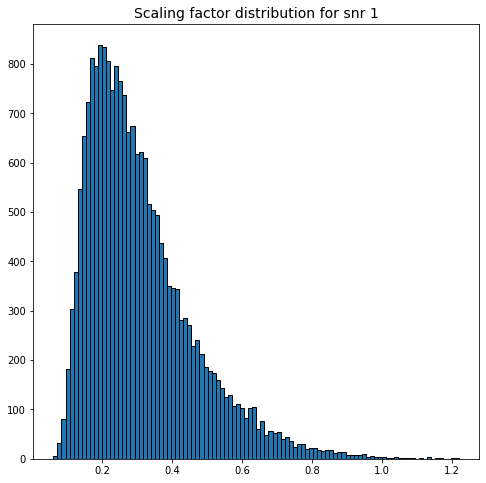

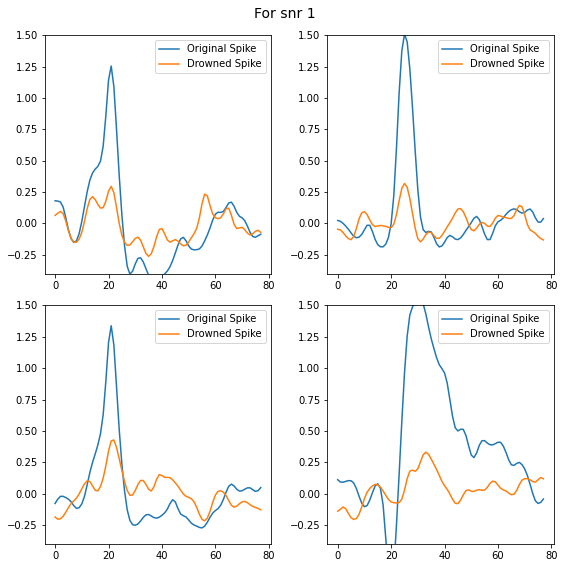

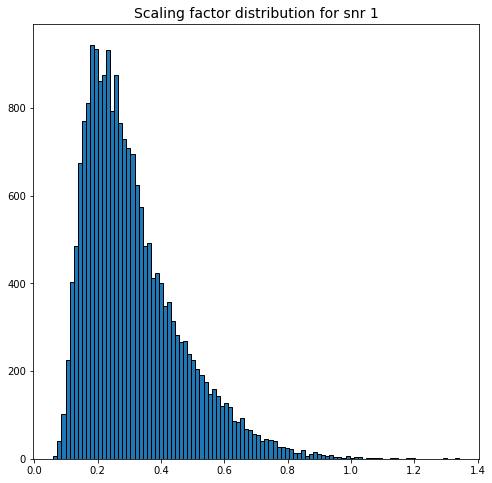

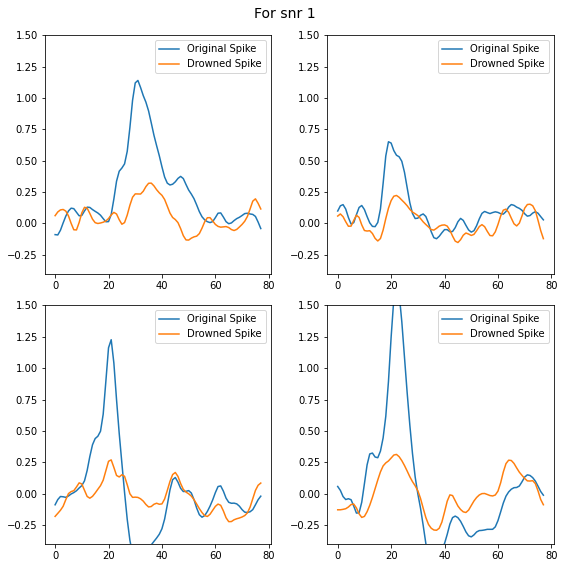

Generating dataset with snr 2


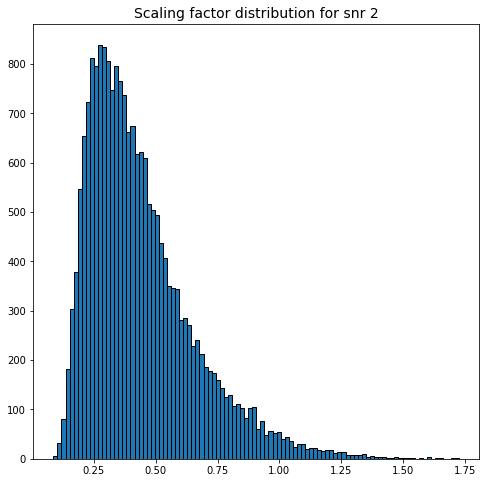

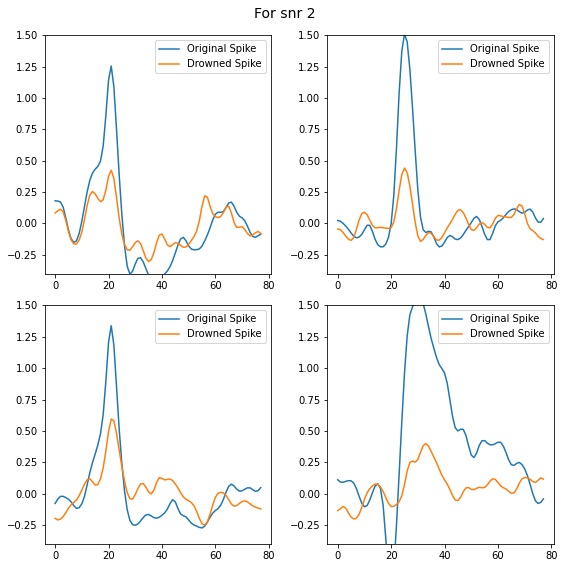

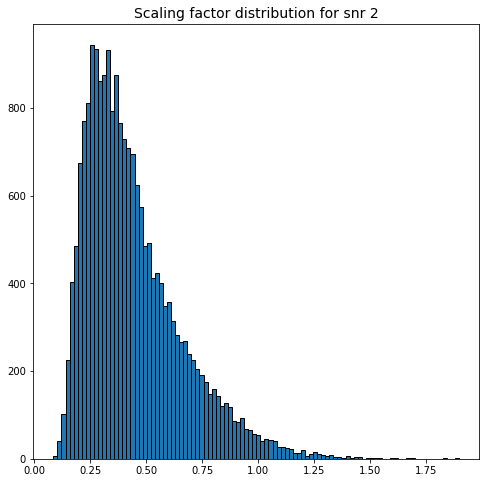

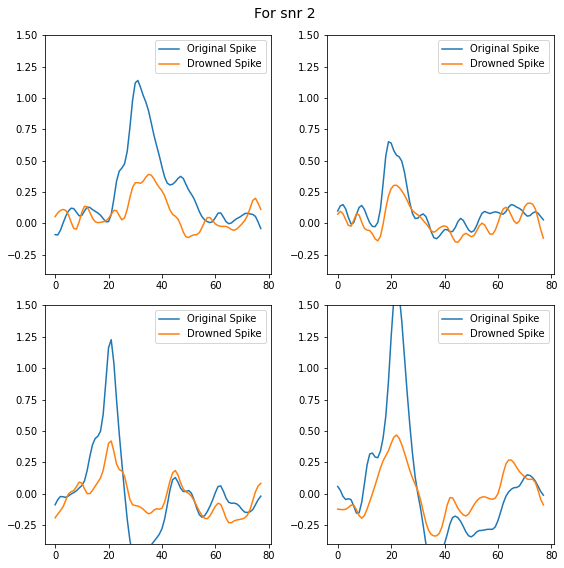

Generating dataset with snr 3


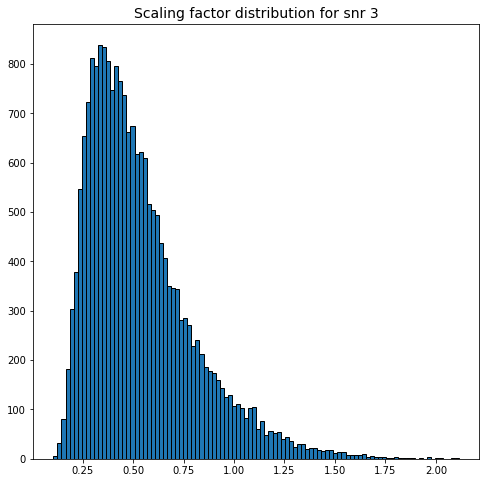

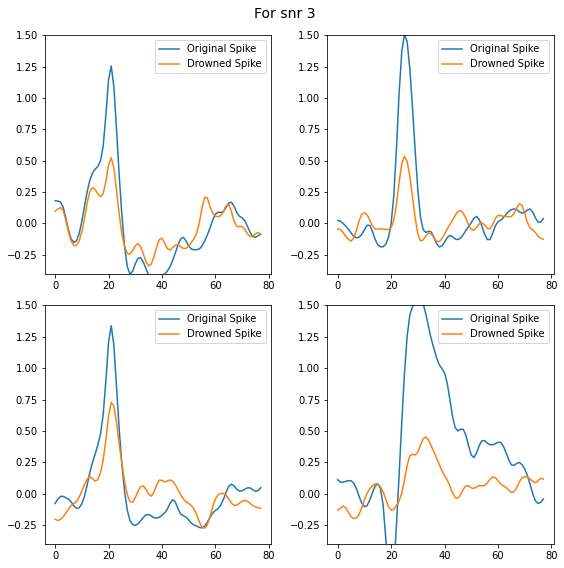

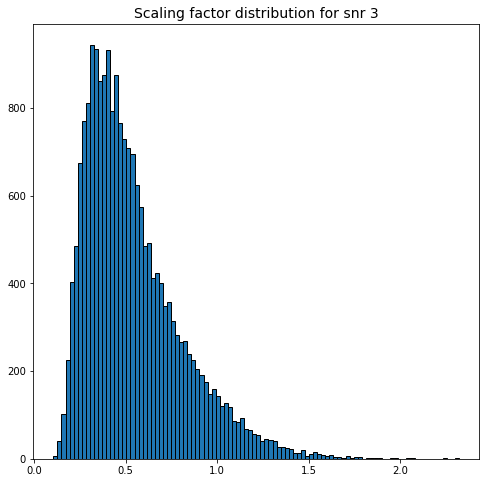

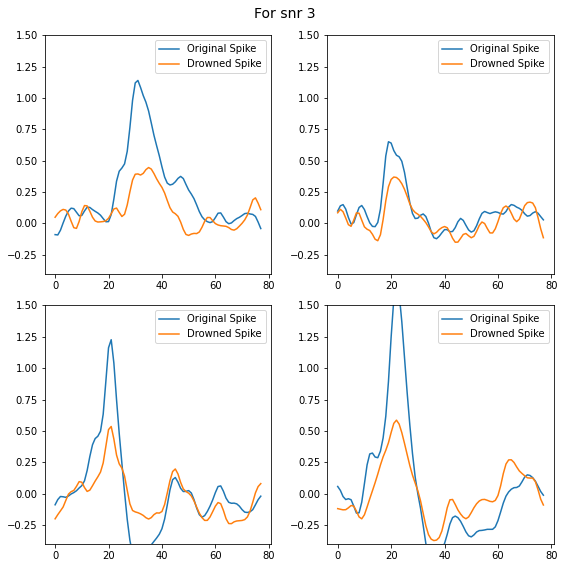

Generating dataset with snr 4


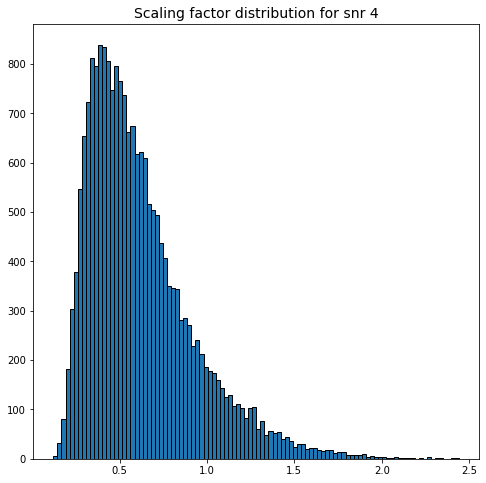

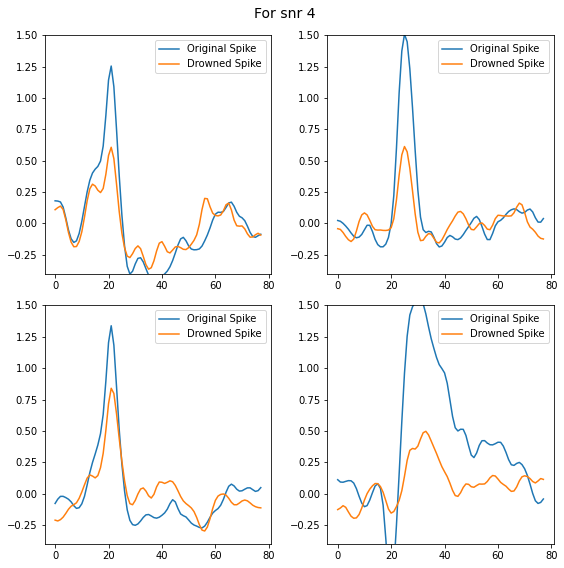

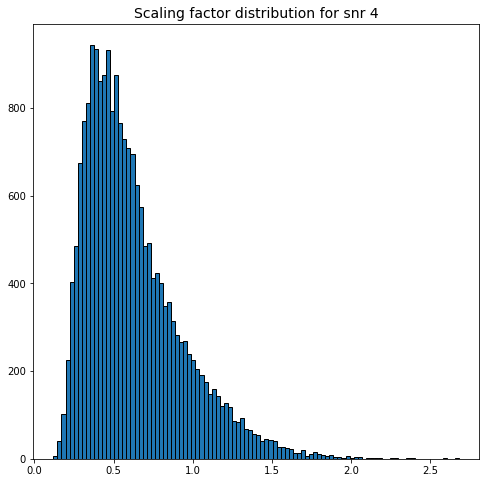

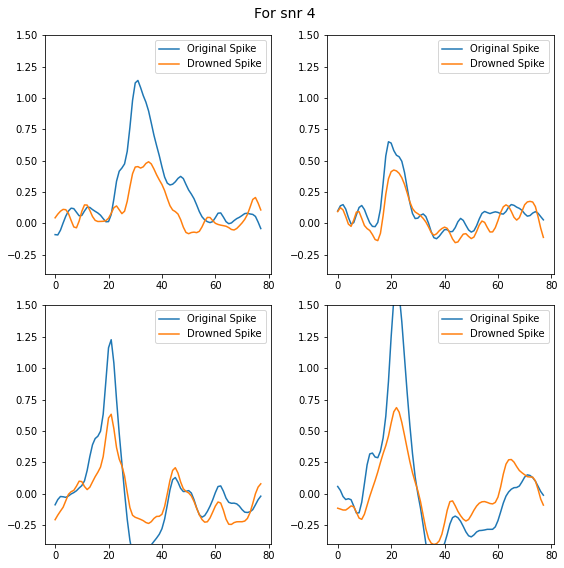

Generating dataset with snr 5


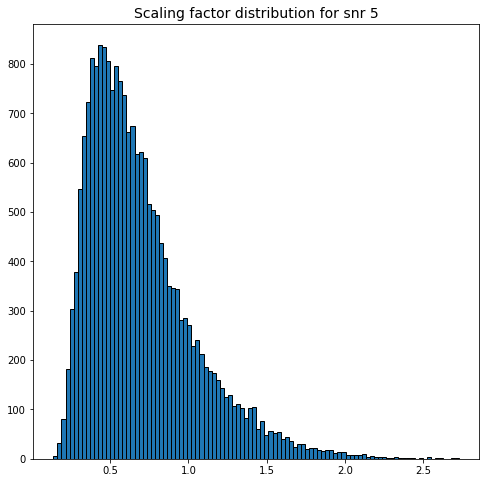

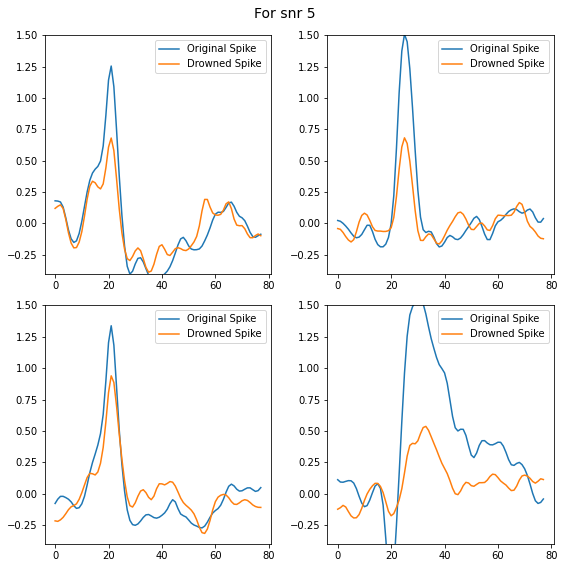

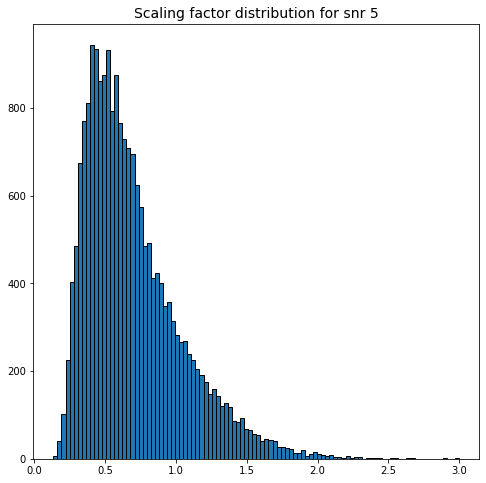

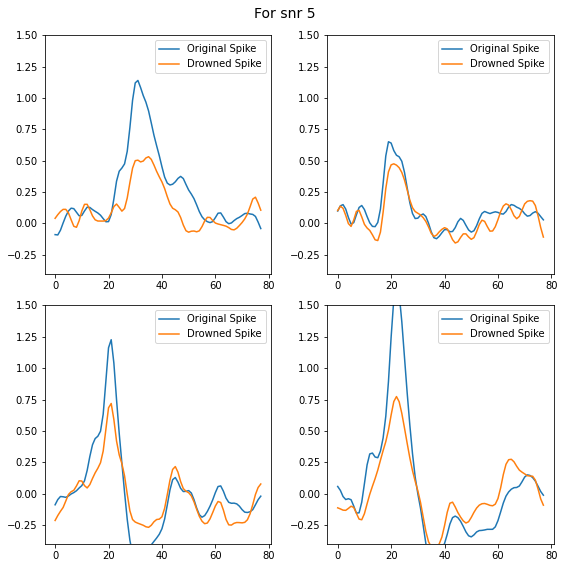

Generating dataset with snr 6


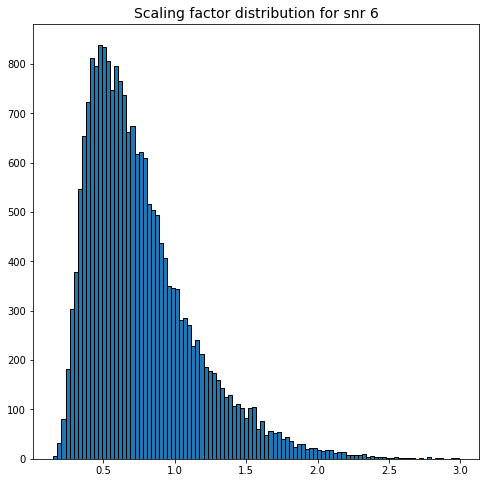

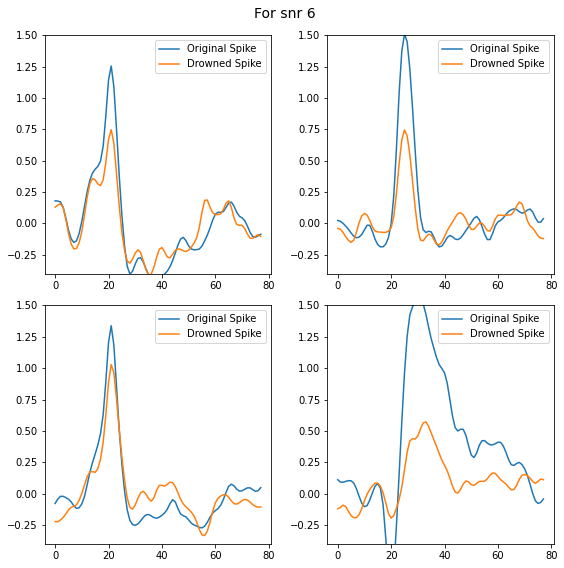

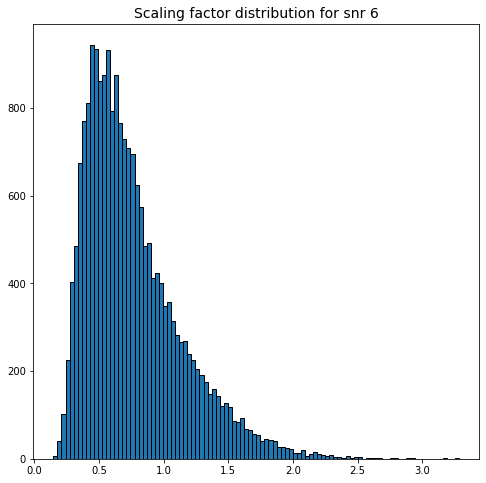

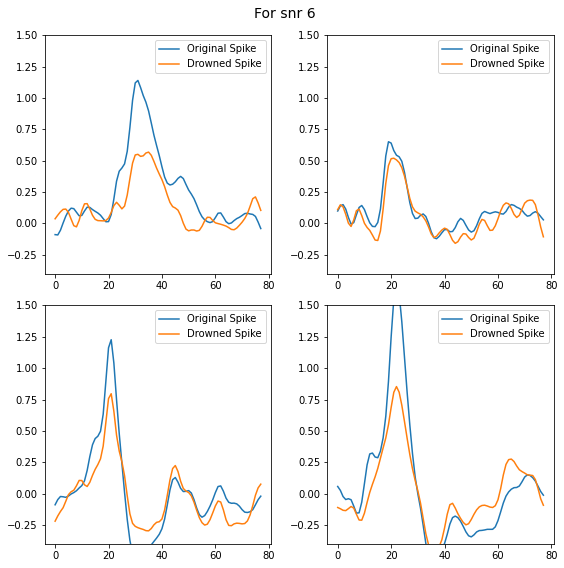

Generating dataset for iteration 2
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


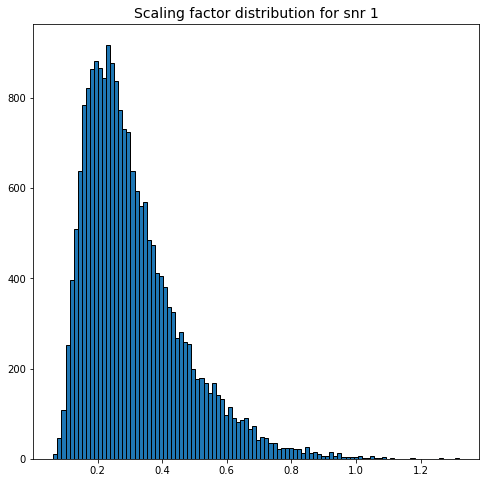

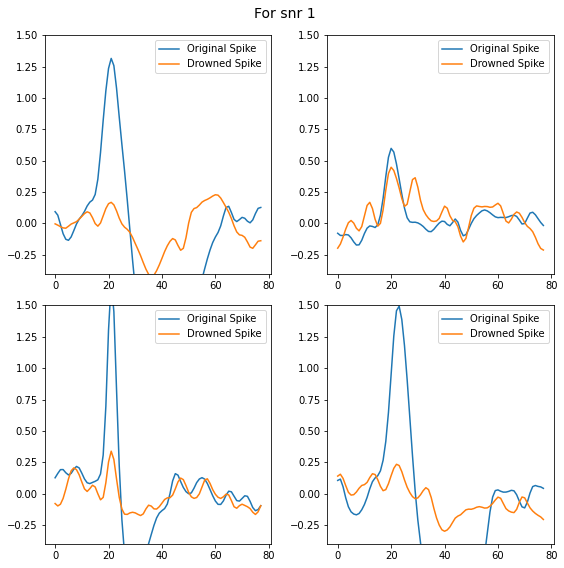

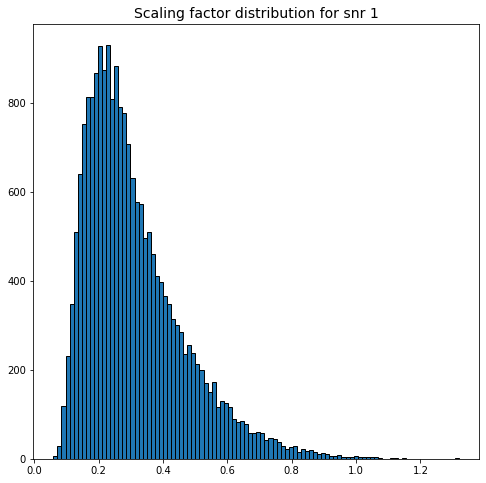

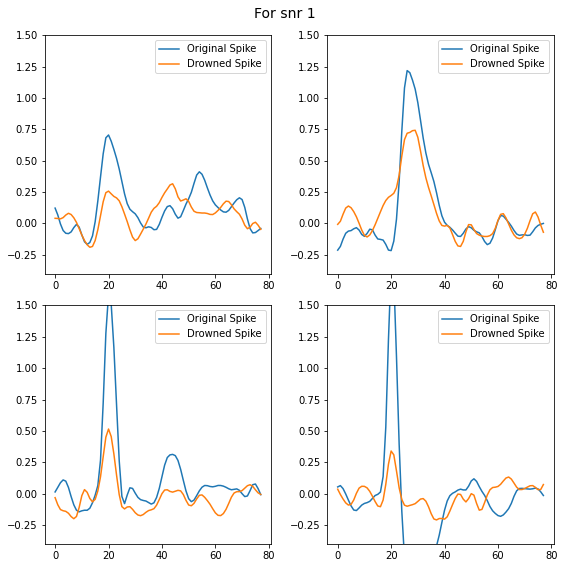

Generating dataset with snr 2


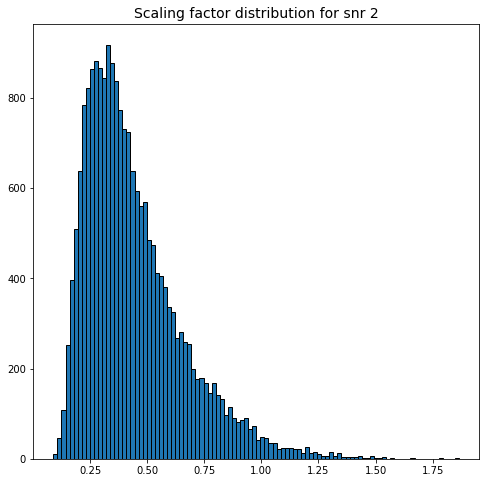

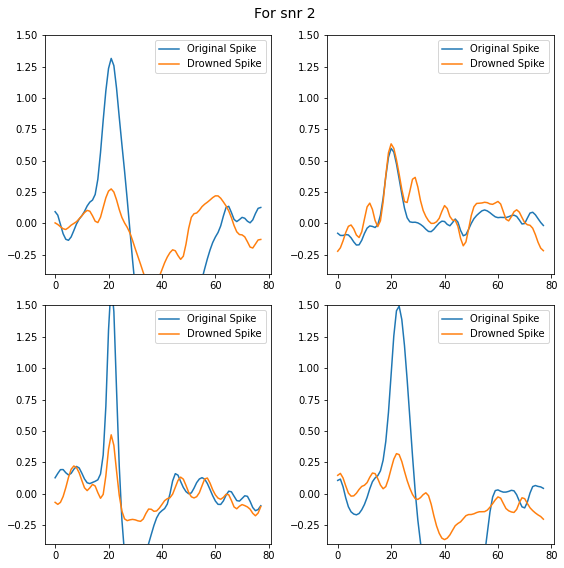

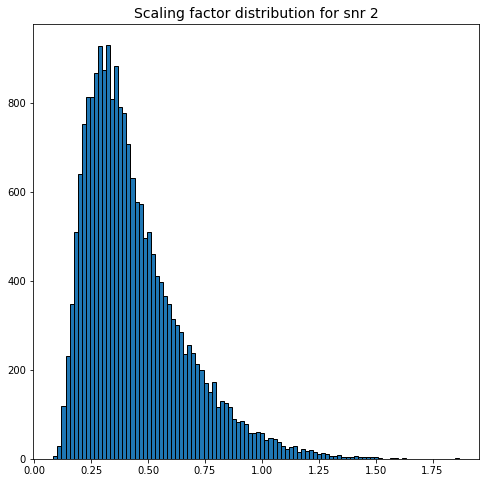

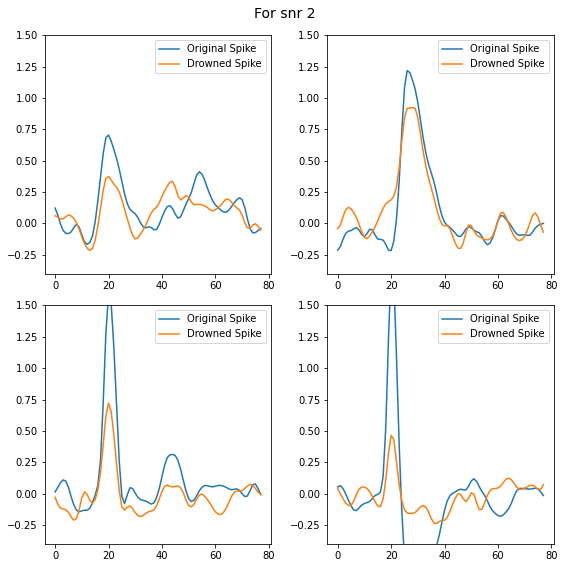

Generating dataset with snr 3


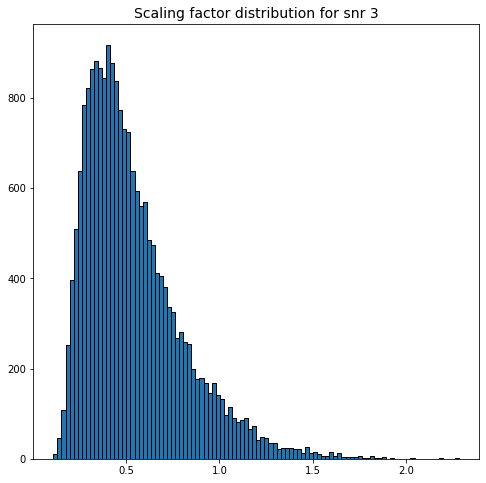

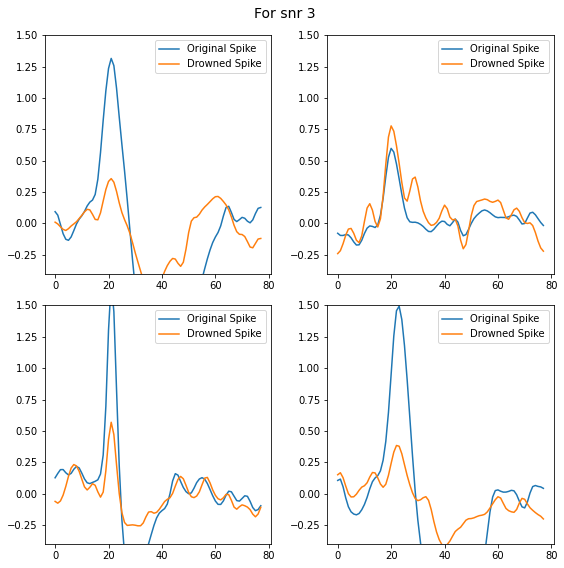

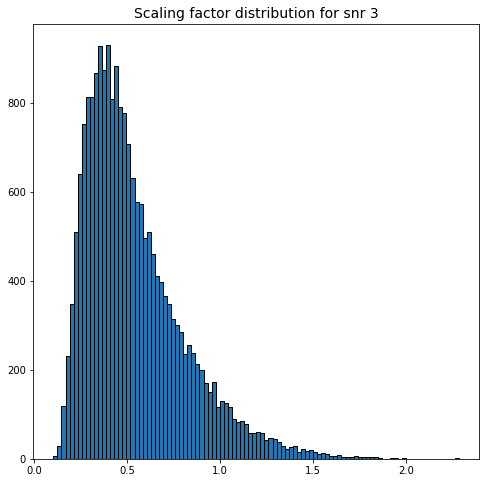

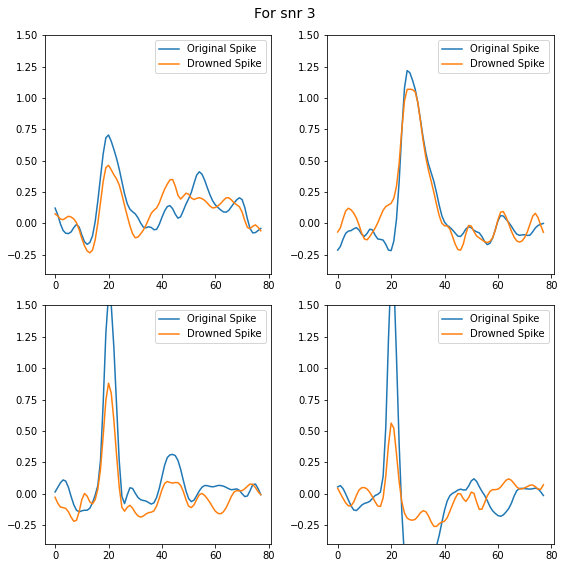

Generating dataset with snr 4


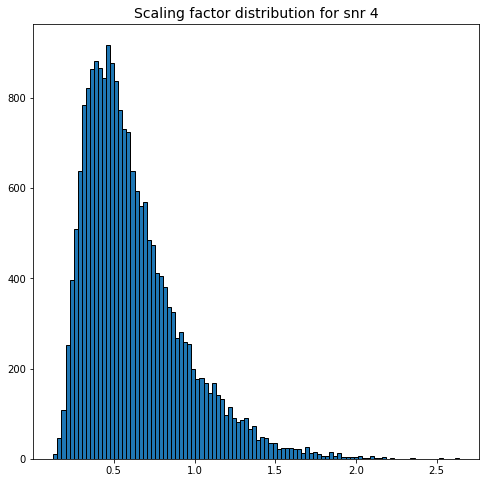

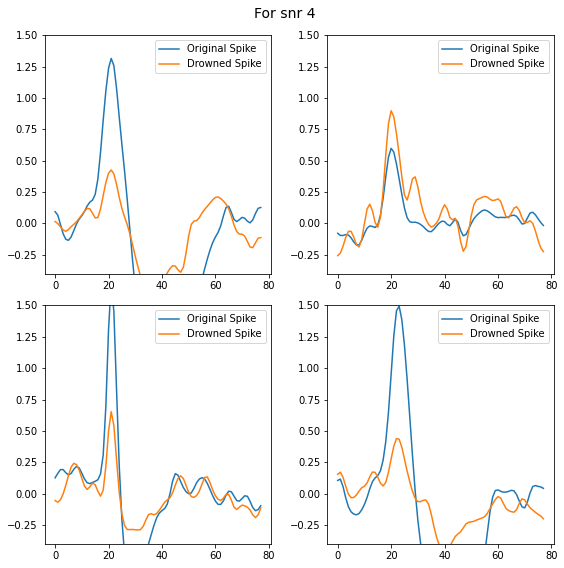

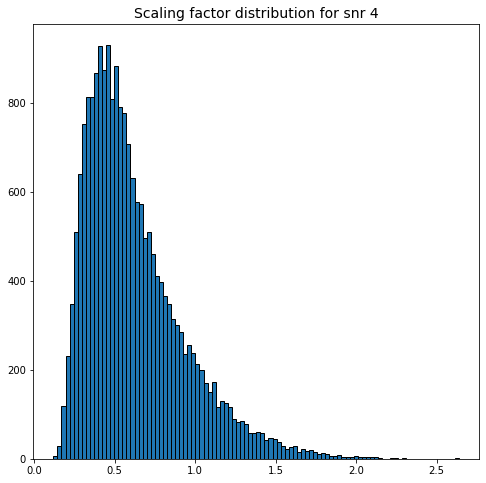

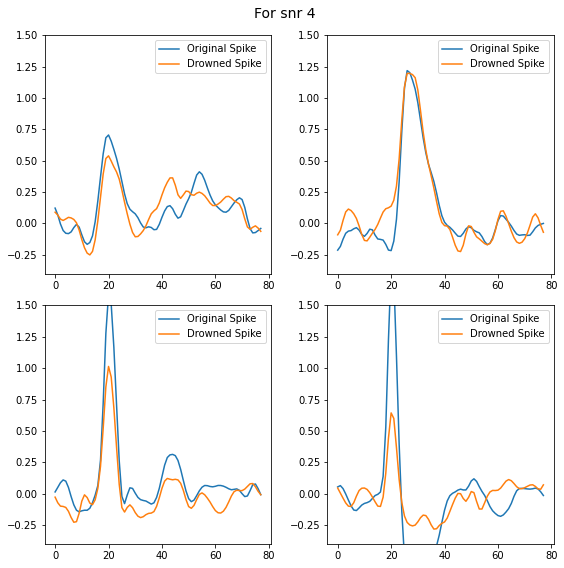

Generating dataset with snr 5


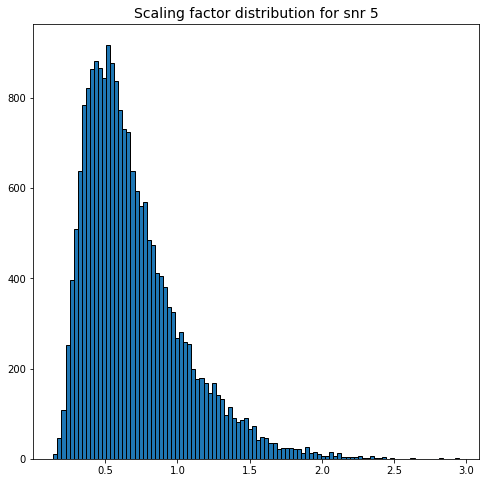

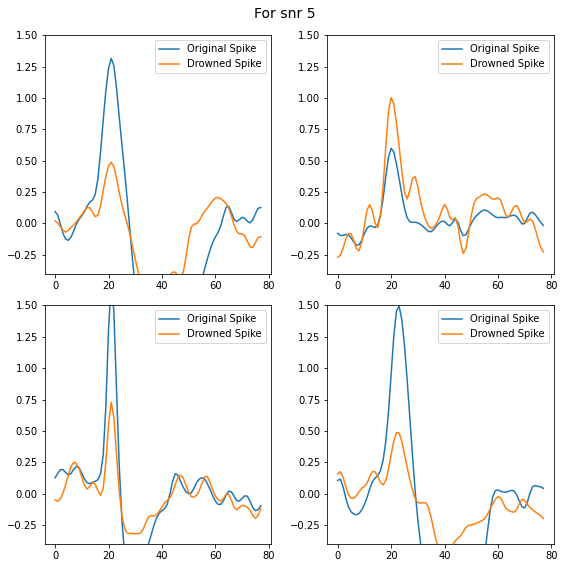

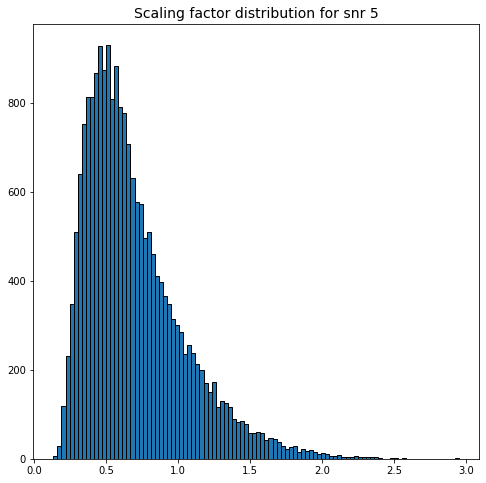

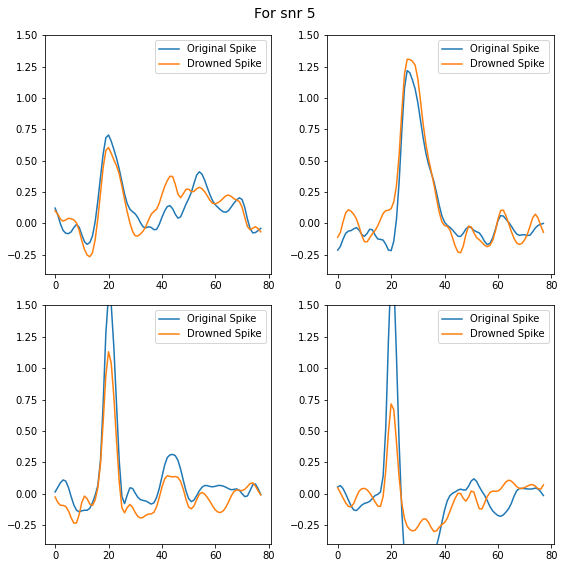

Generating dataset with snr 6


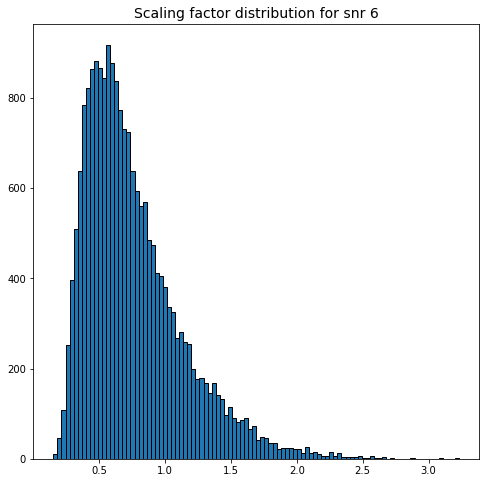

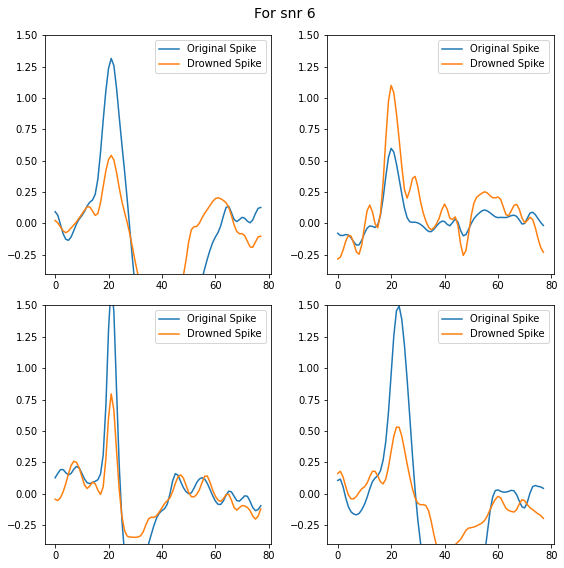

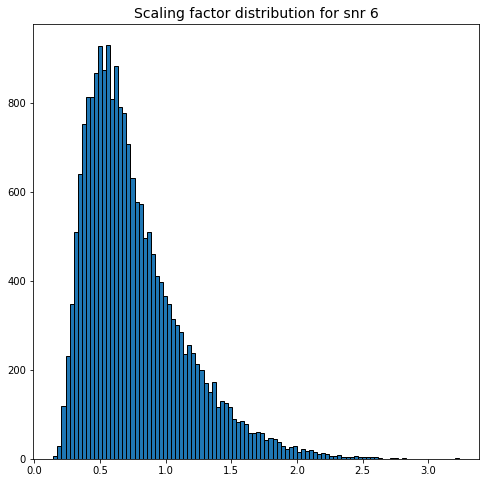

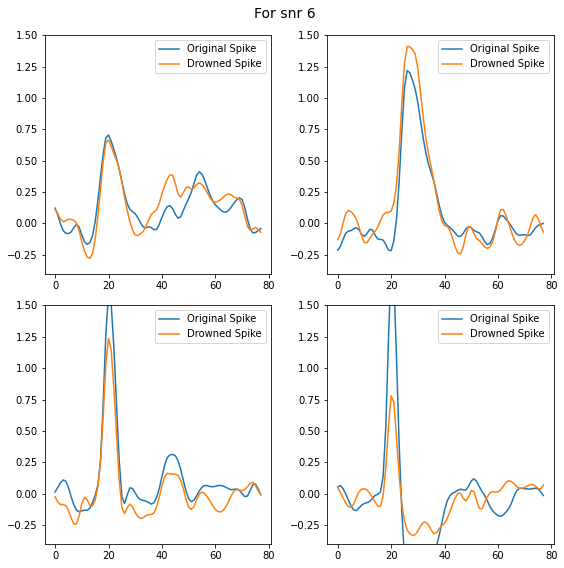

Generating dataset for iteration 3
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


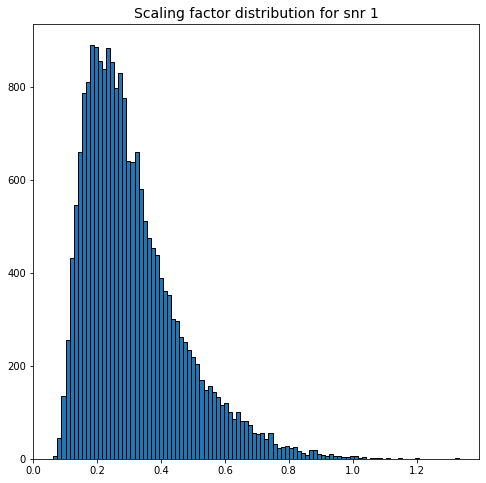

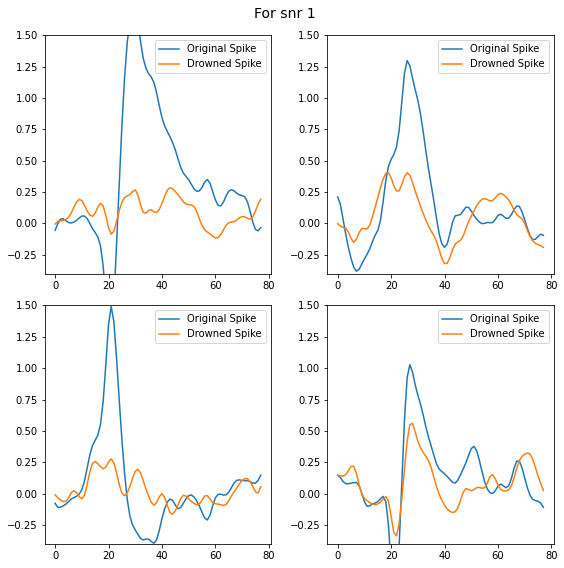

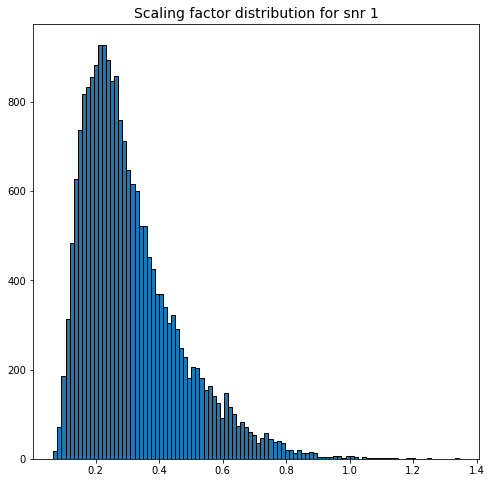

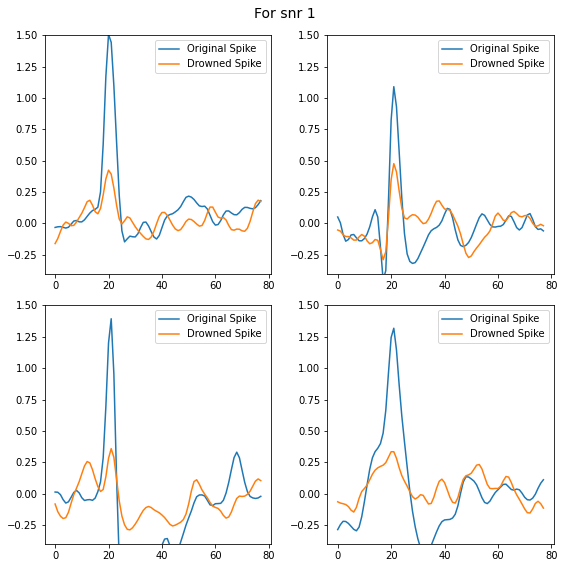

Generating dataset with snr 2


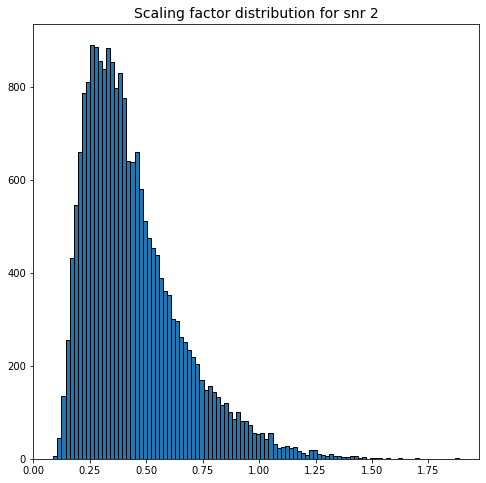

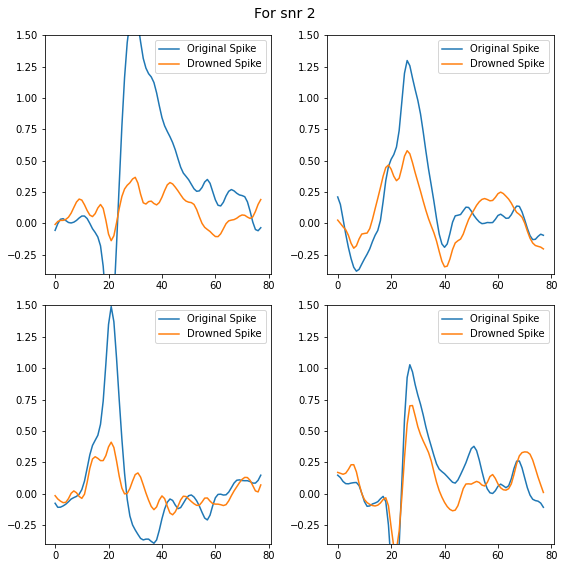

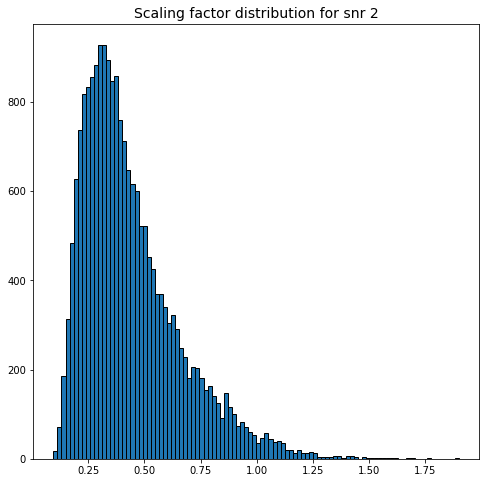

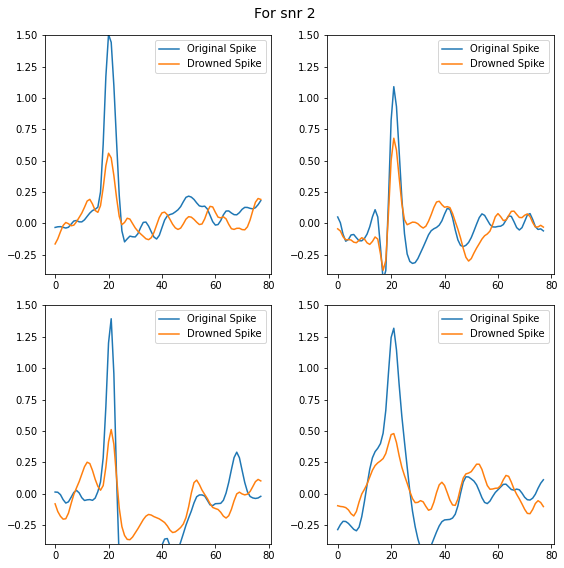

Generating dataset with snr 3


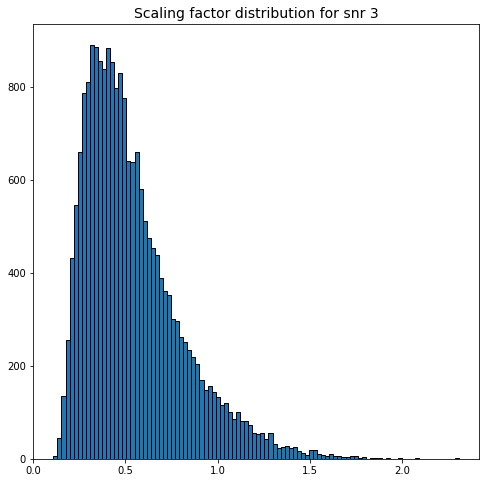

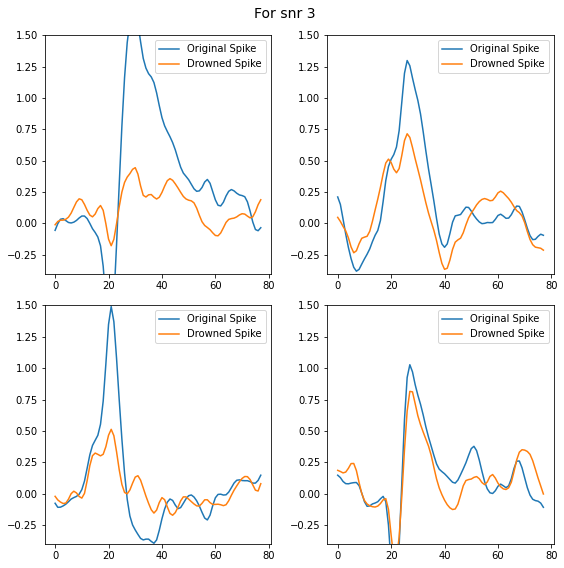

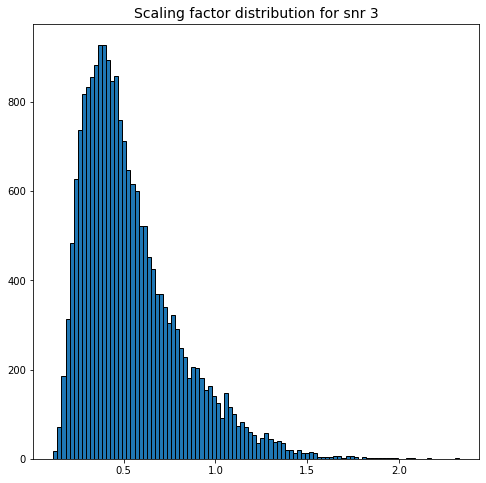

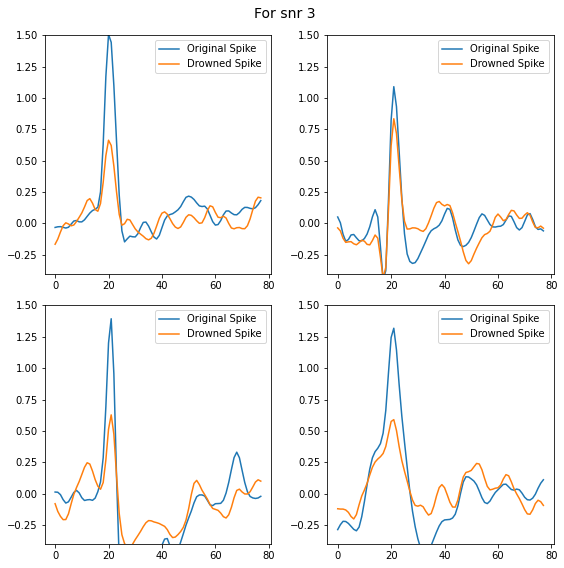

Generating dataset with snr 4


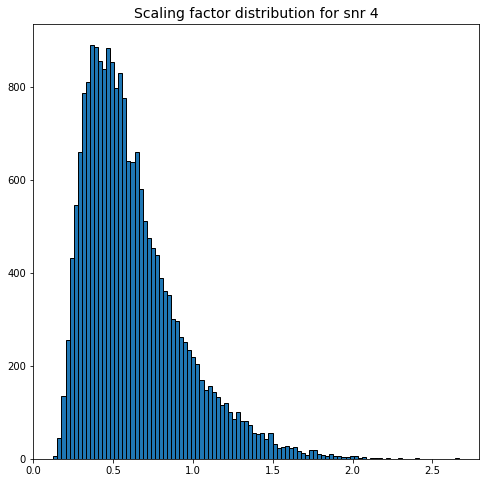

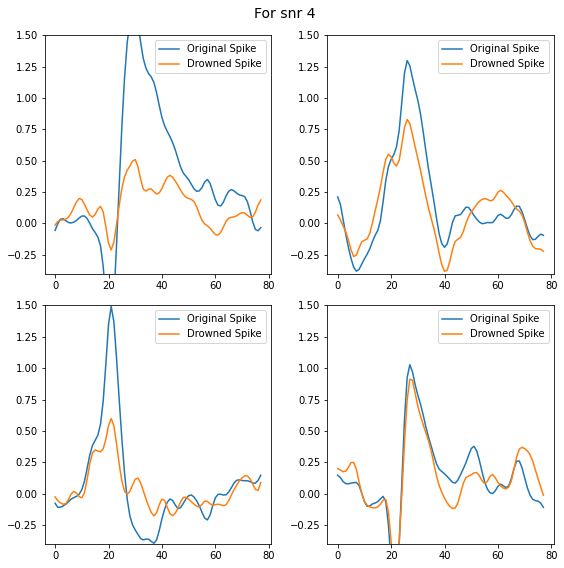

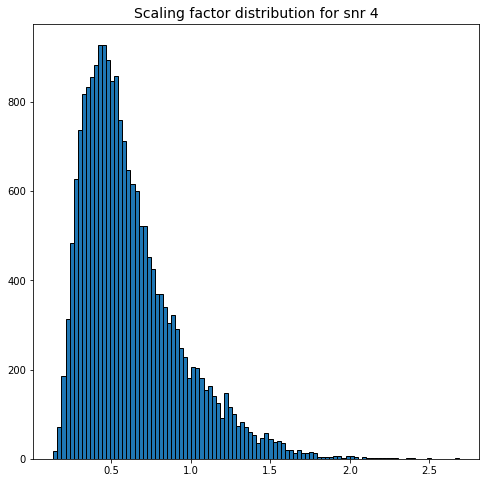

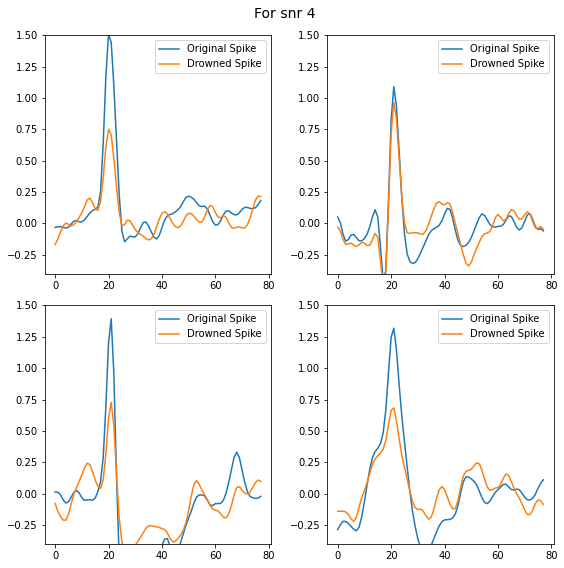

Generating dataset with snr 5


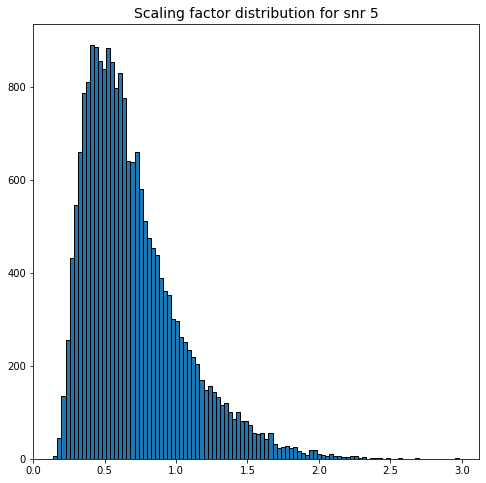

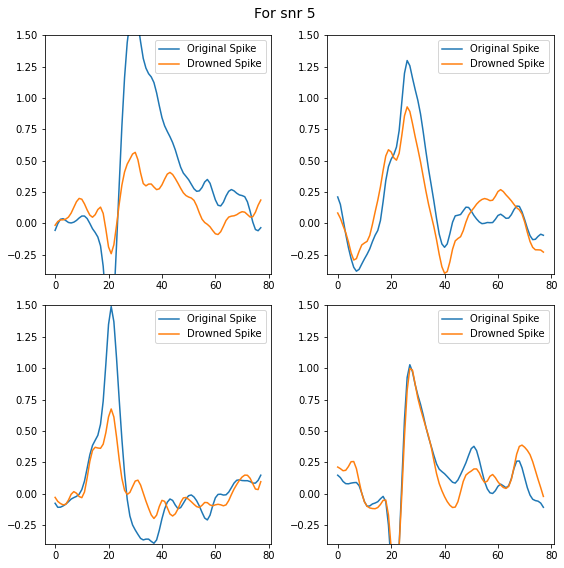

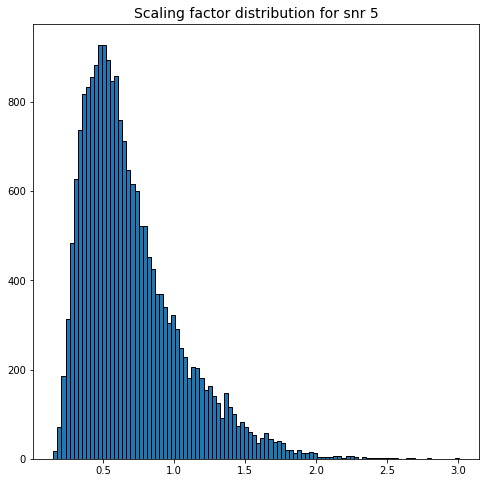

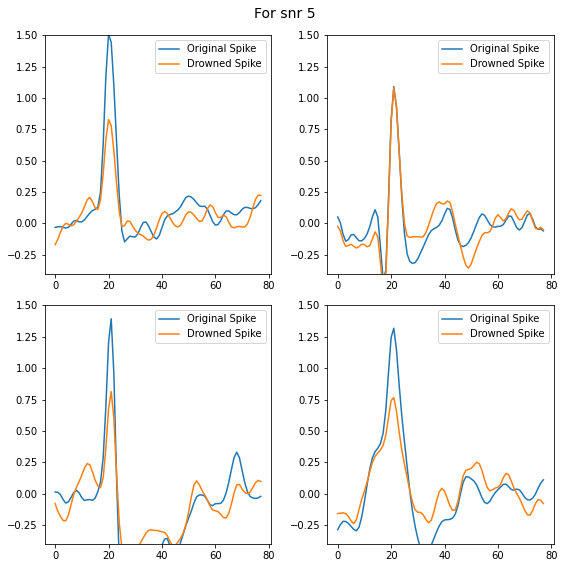

Generating dataset with snr 6


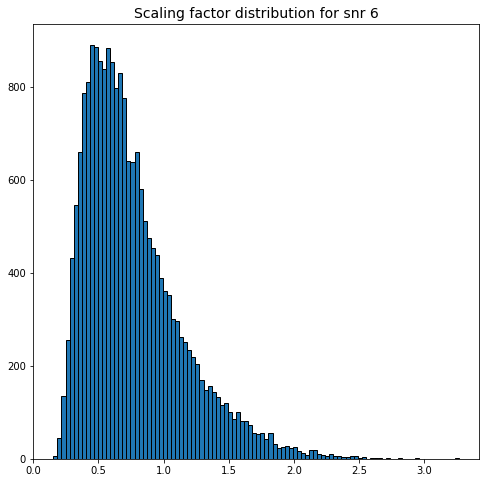

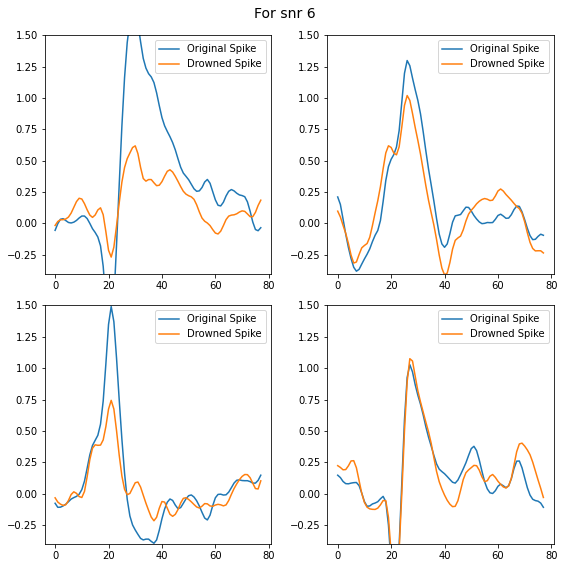

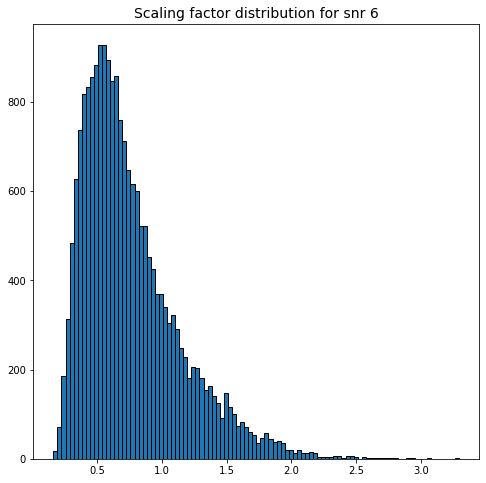

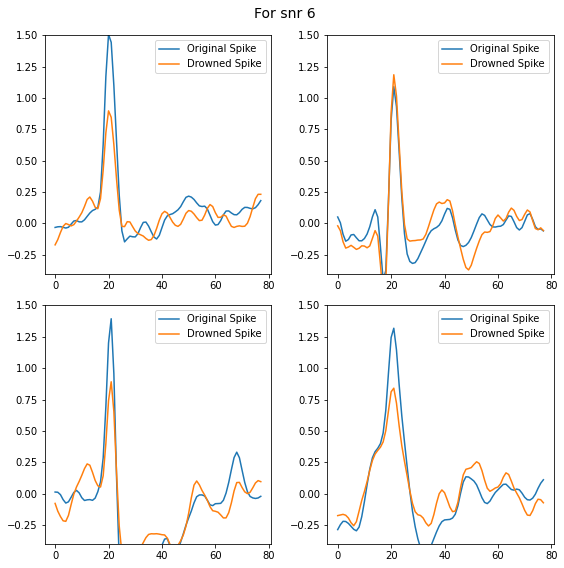

Generating dataset for iteration 4
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


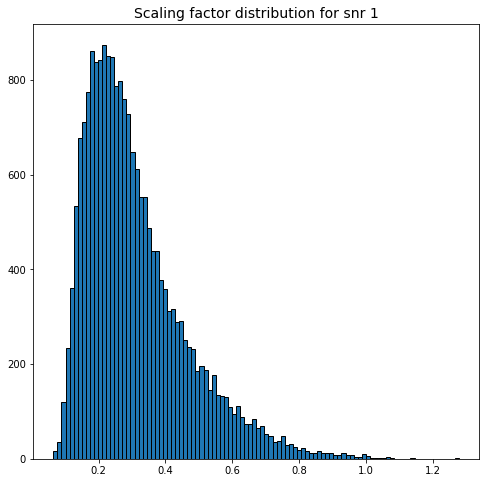

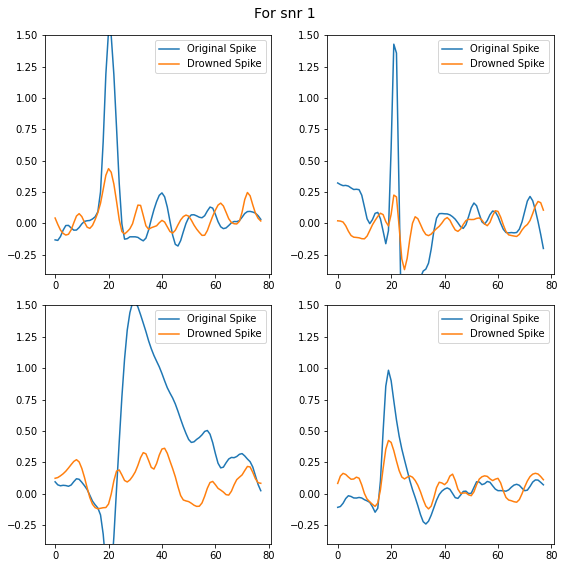

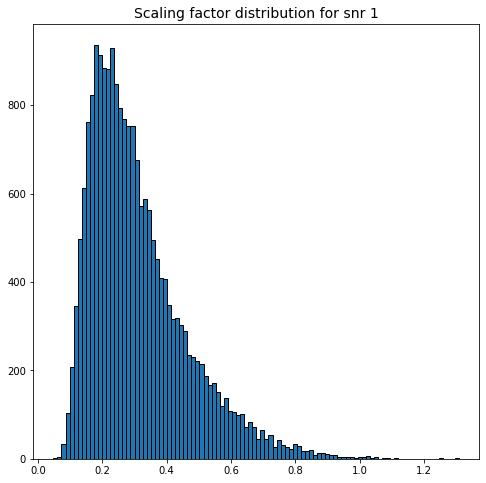

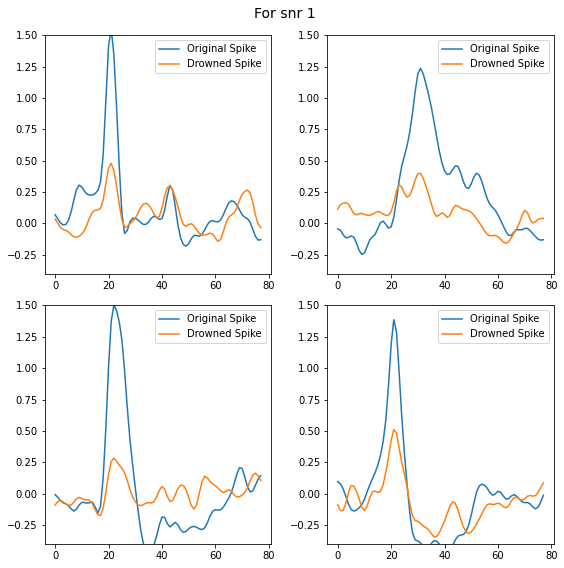

Generating dataset with snr 2


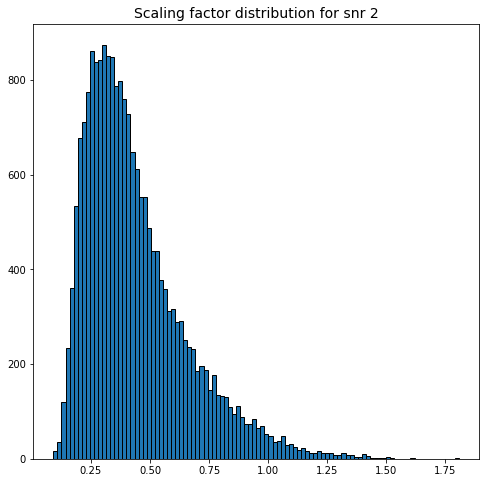

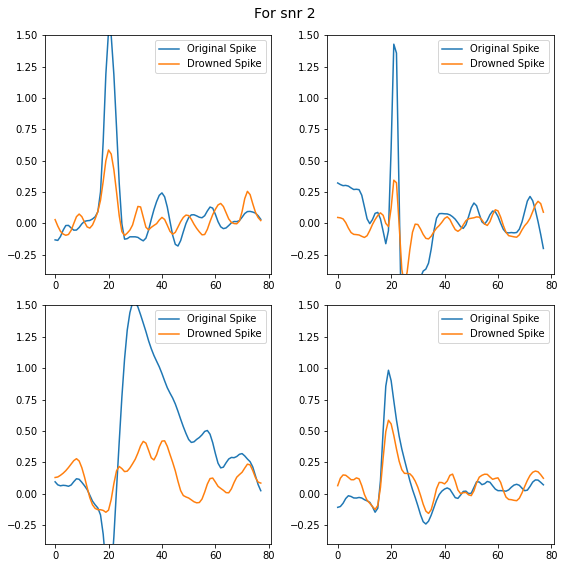

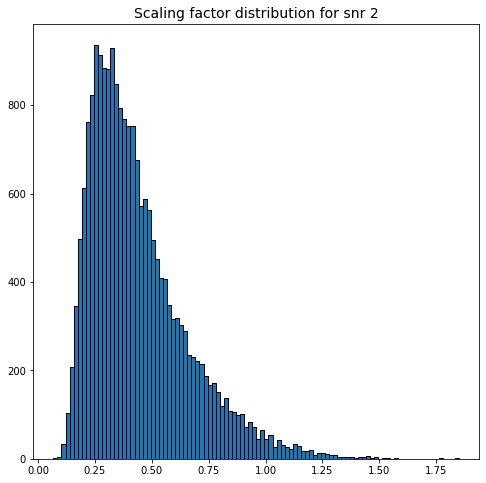

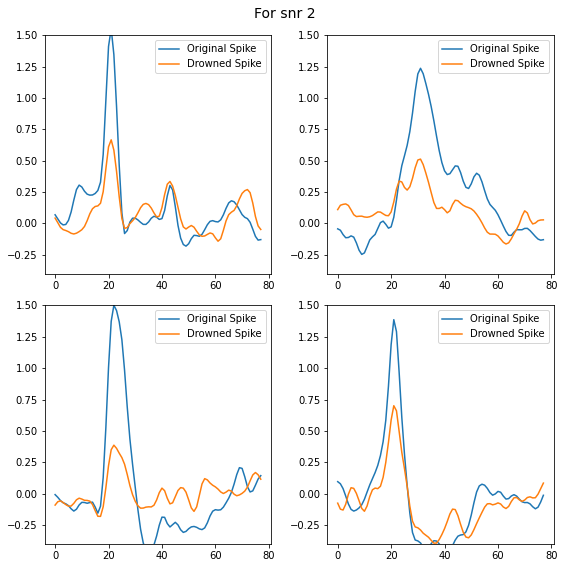

Generating dataset with snr 3


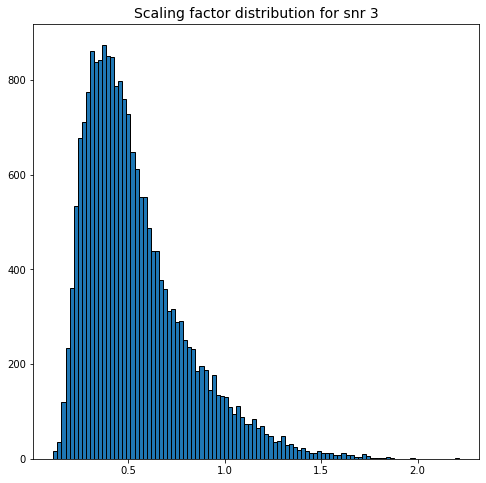

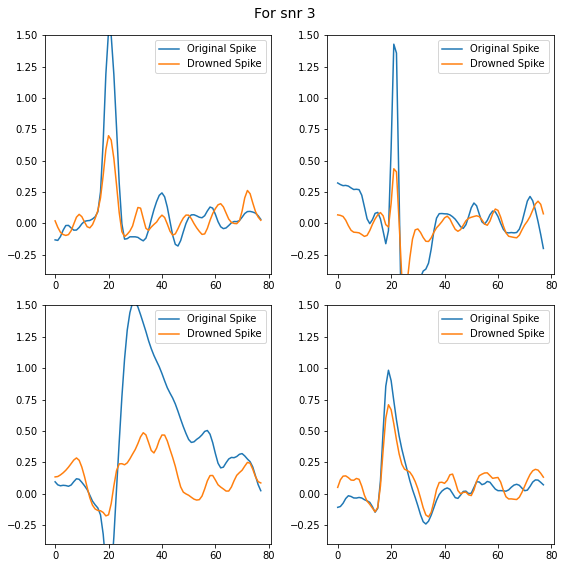

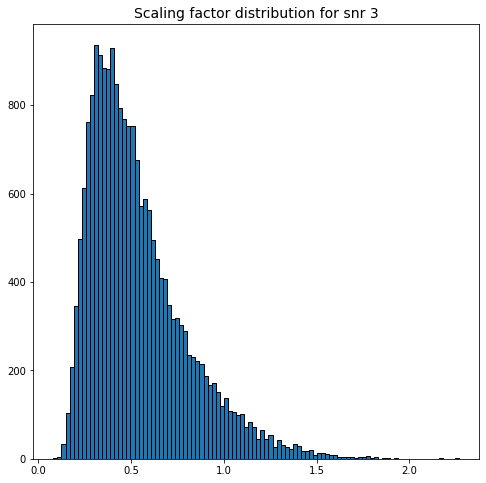

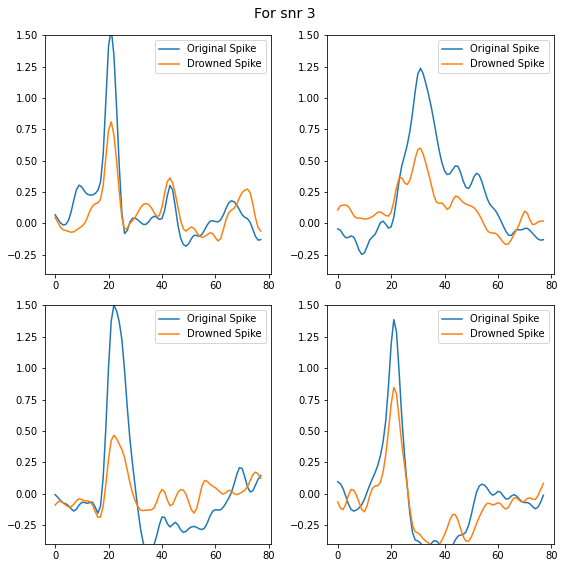

Generating dataset with snr 4


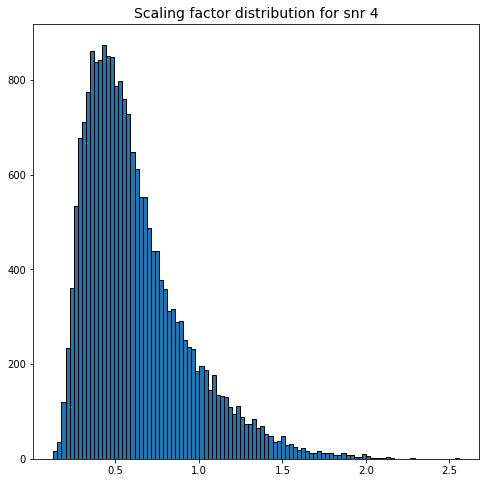

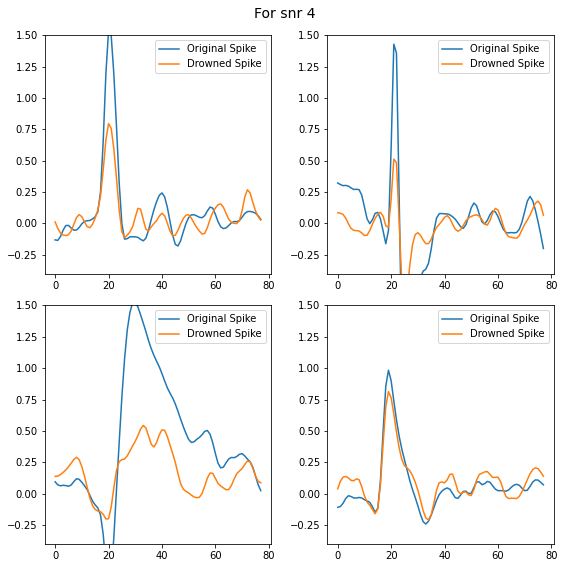

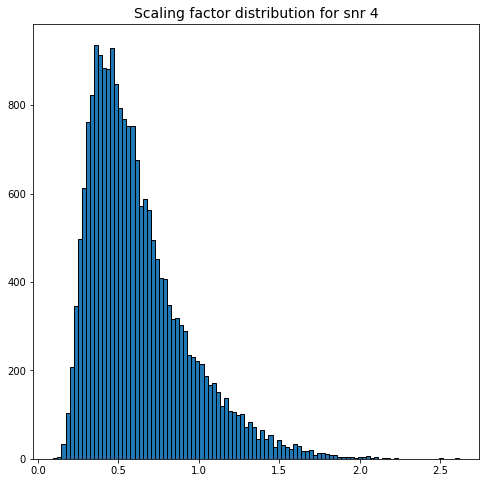

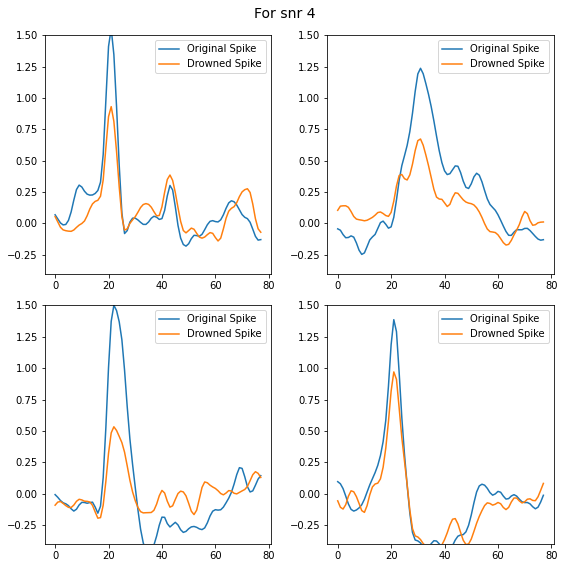

Generating dataset with snr 5


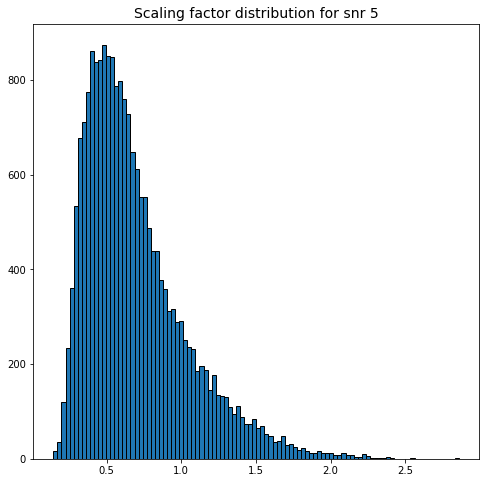

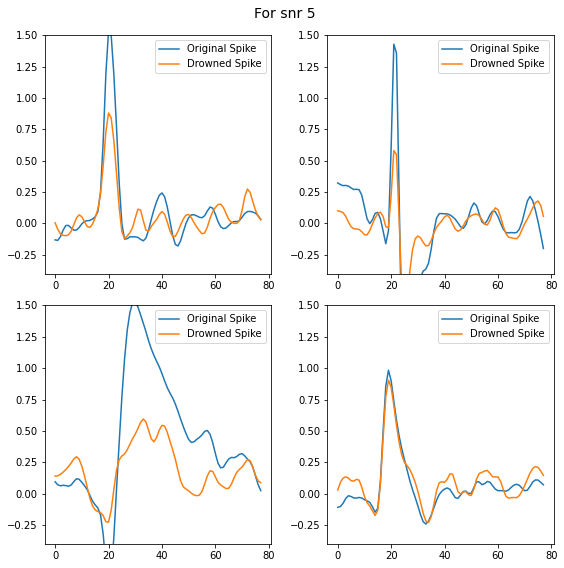

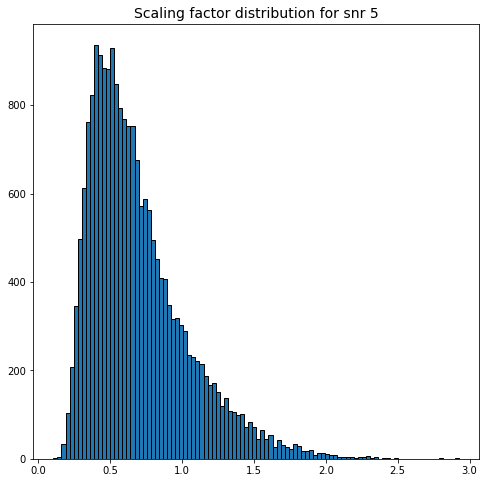

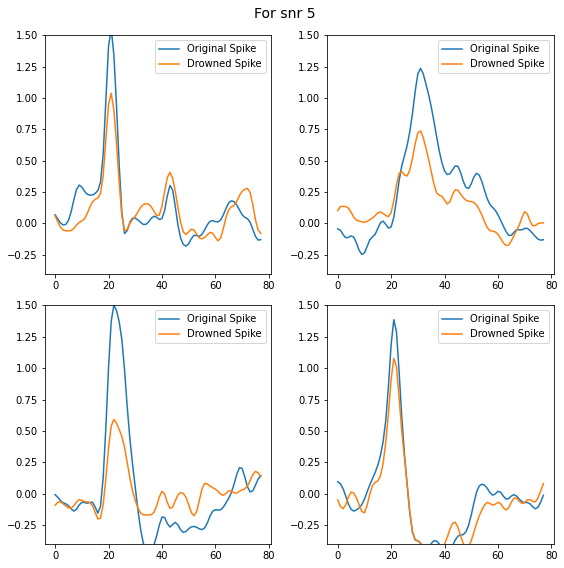

Generating dataset with snr 6


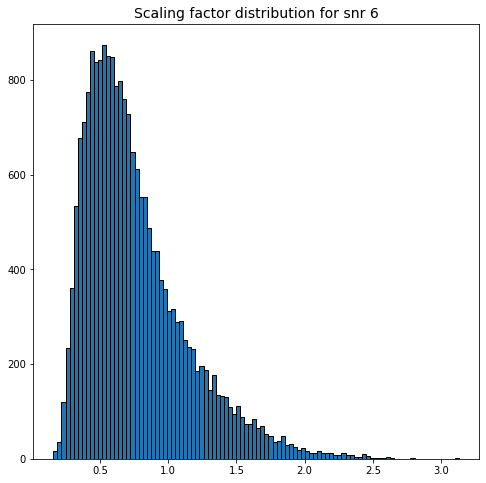

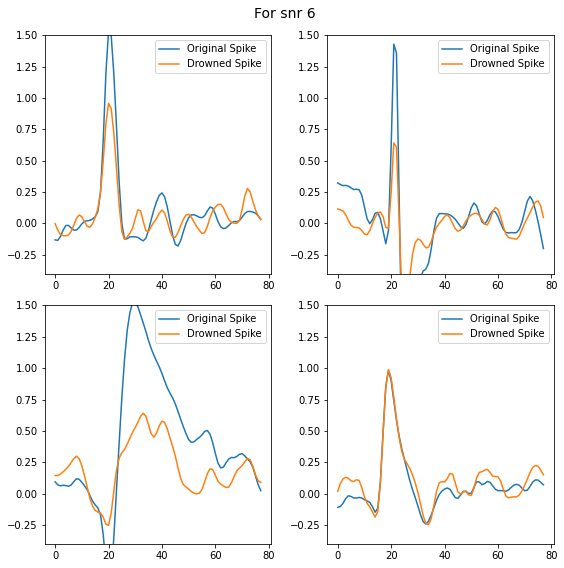

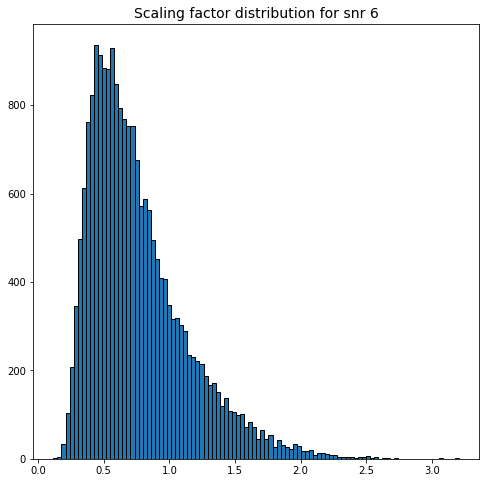

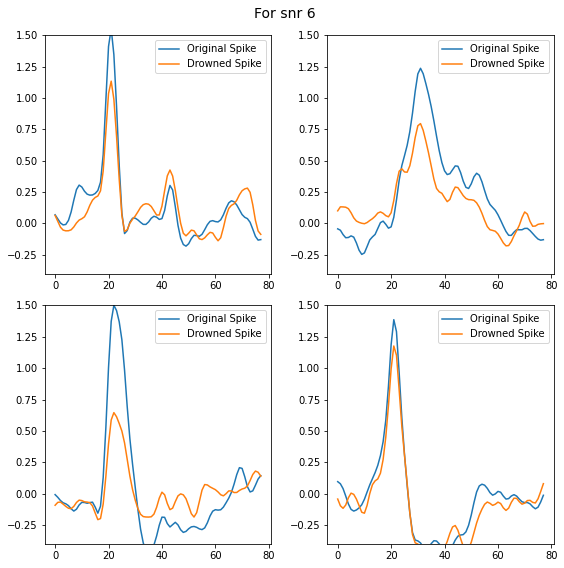

Generating dataset for iteration 5
Processing Simulation: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 
Generating non-drowned segment of dataset
Generating dataset with snr 1


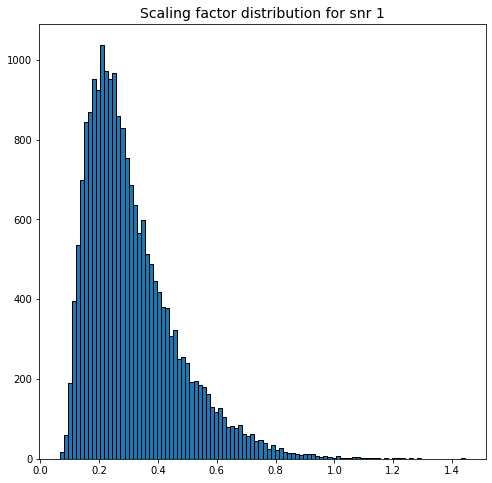

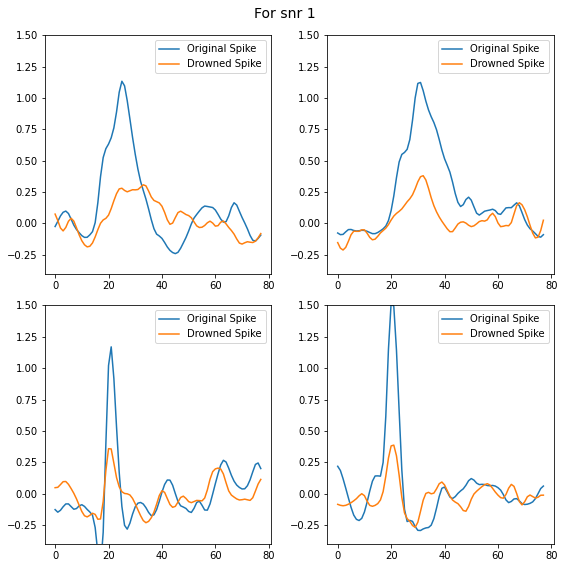

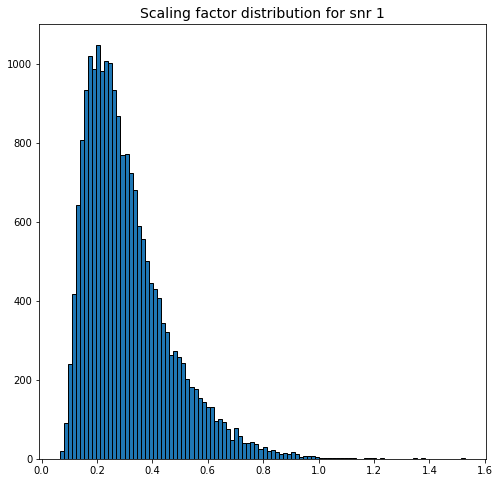

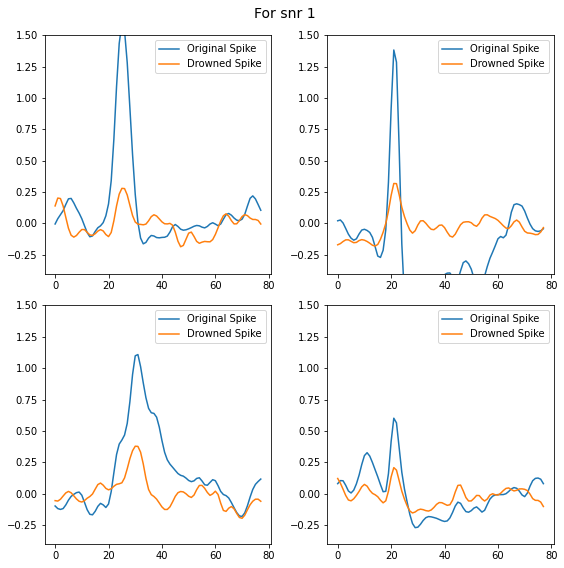

Generating dataset with snr 2


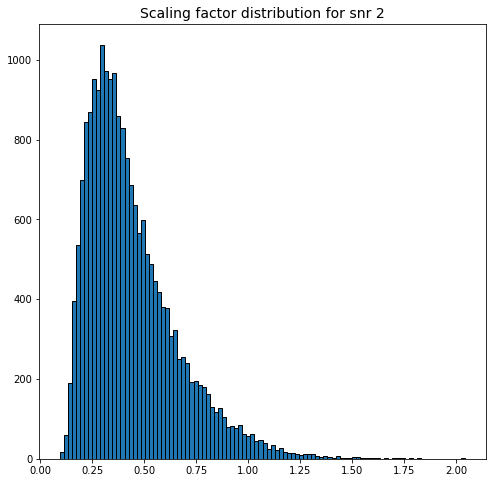

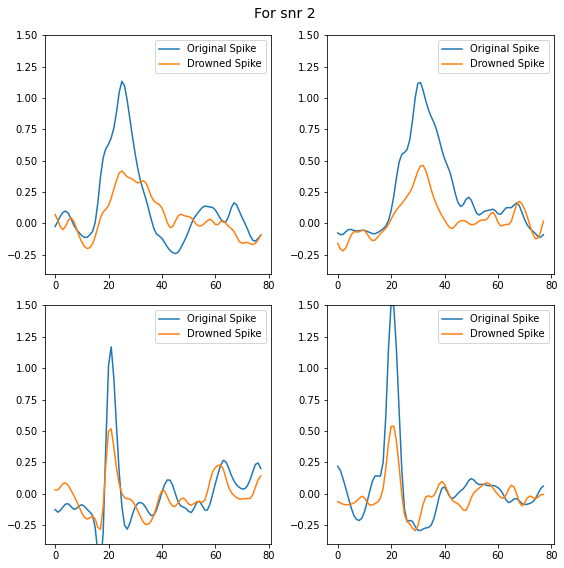

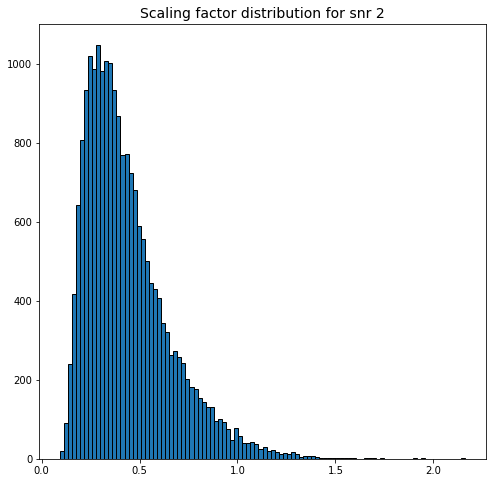

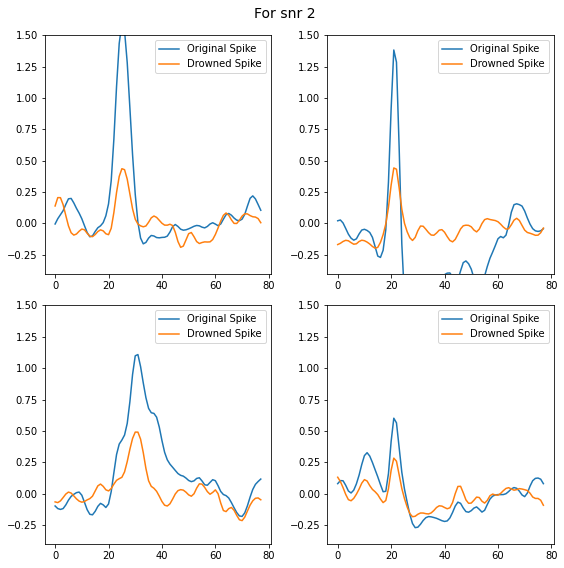

Generating dataset with snr 3


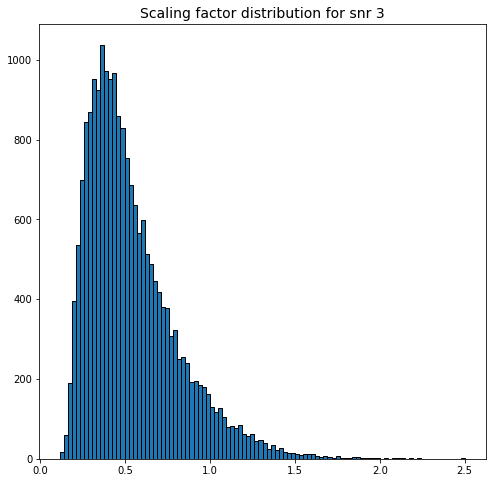

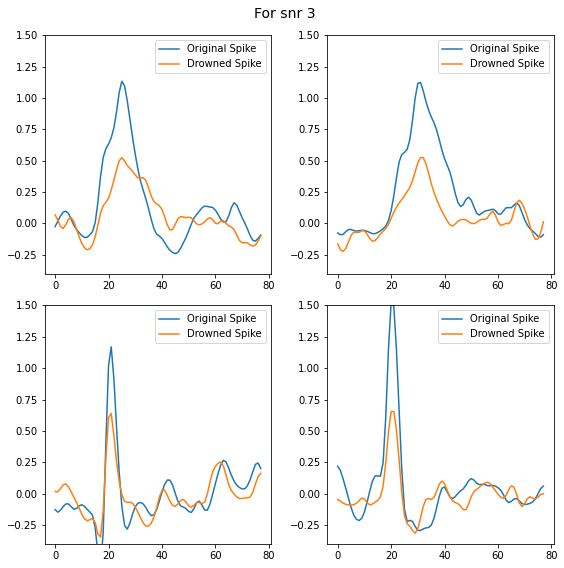

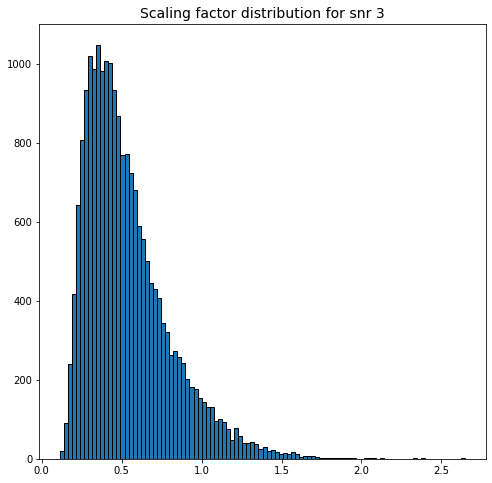

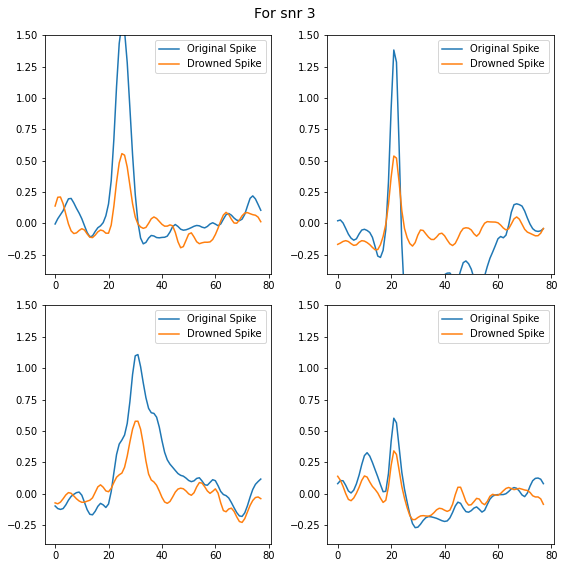

Generating dataset with snr 4


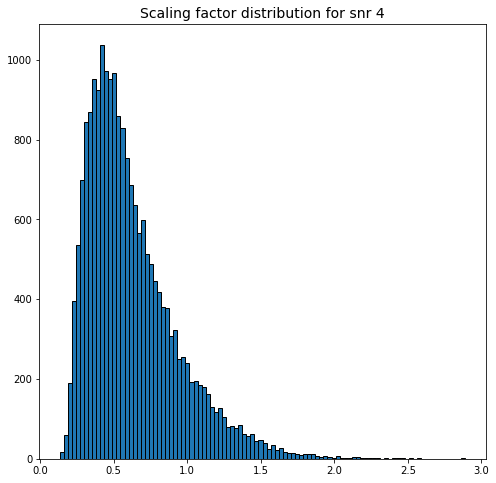

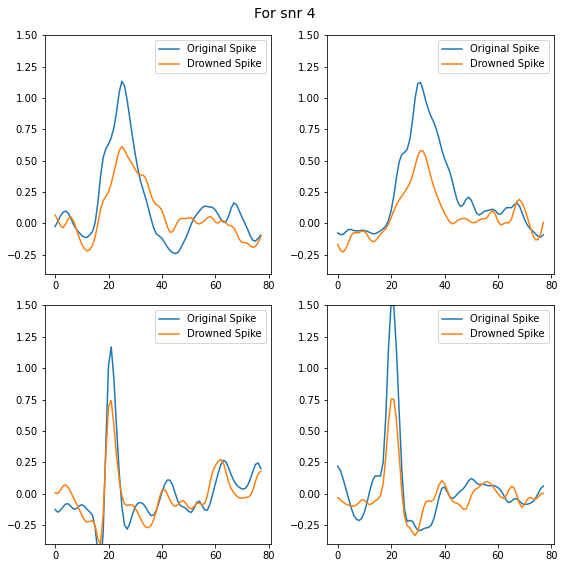

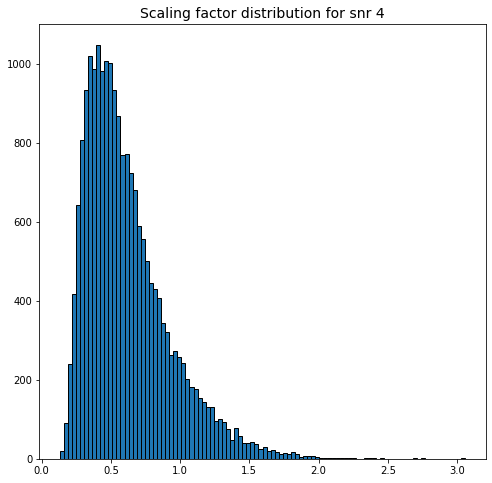

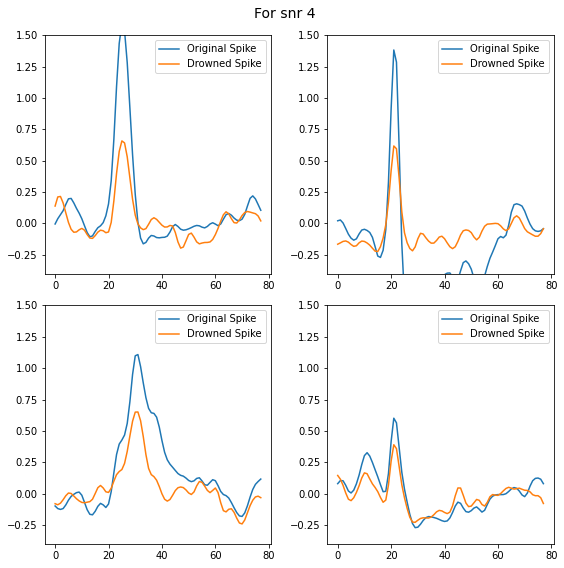

Generating dataset with snr 5


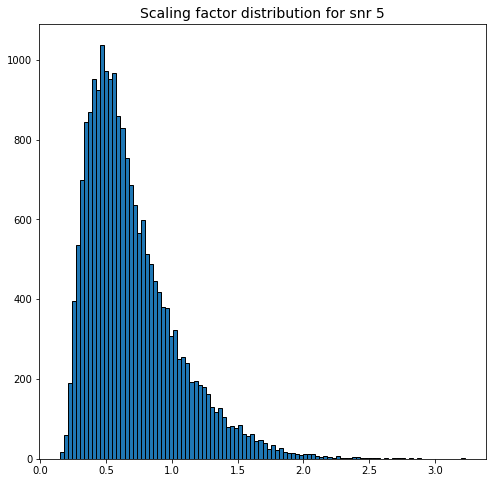

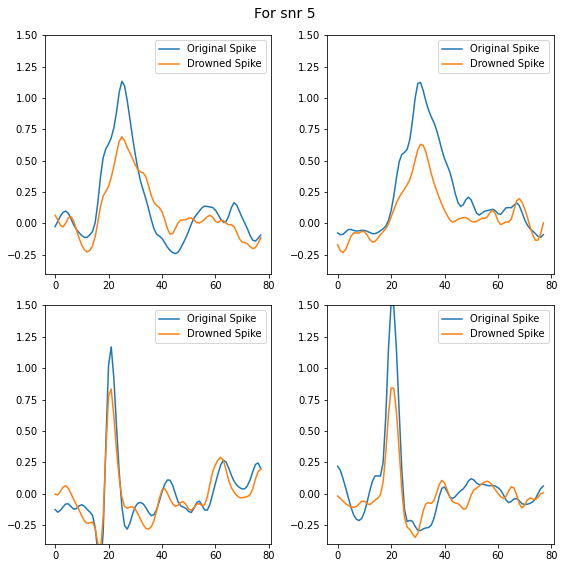

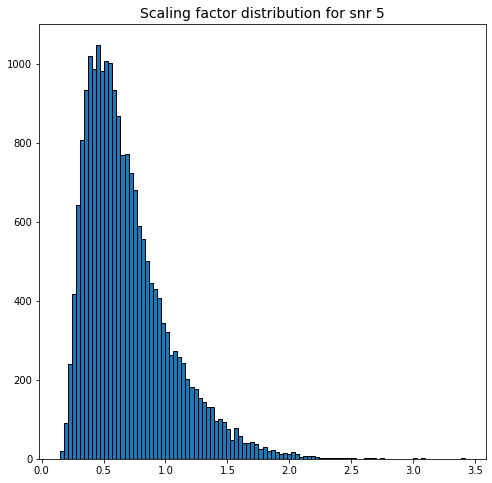

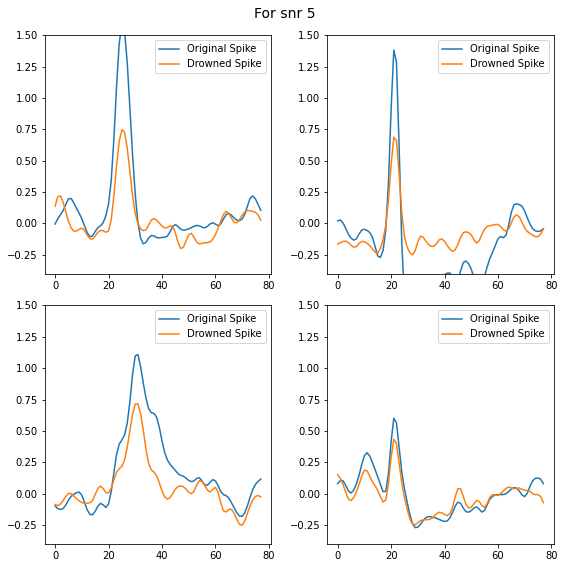

Generating dataset with snr 6


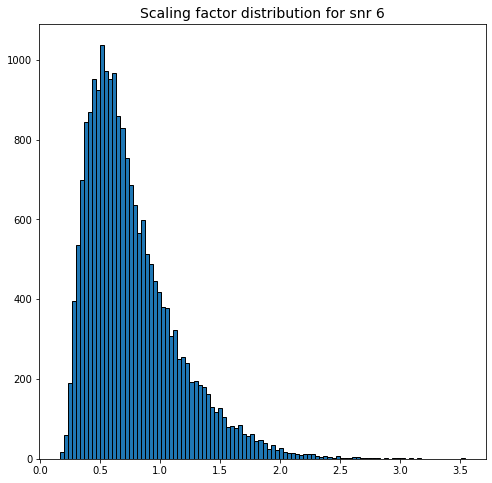

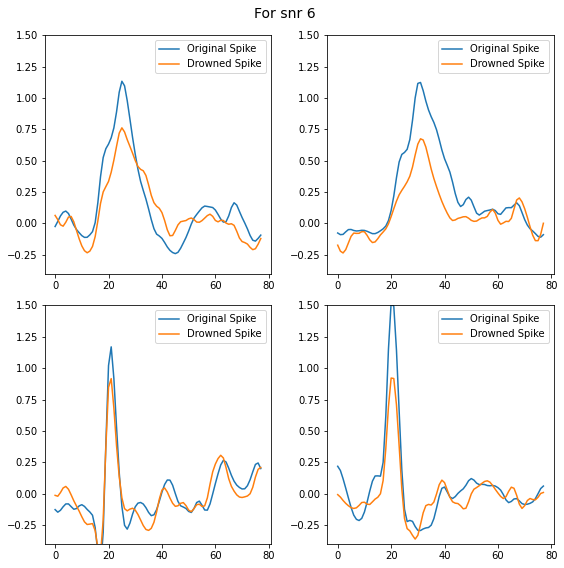

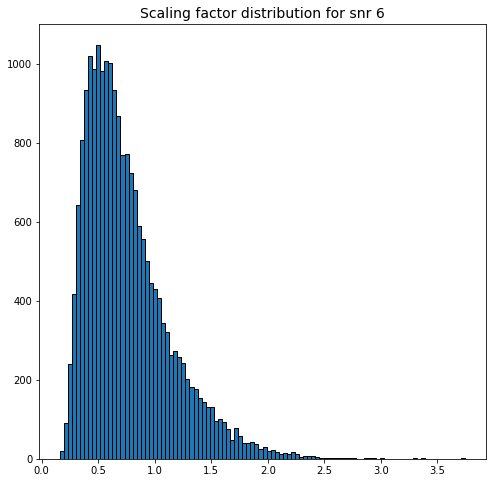

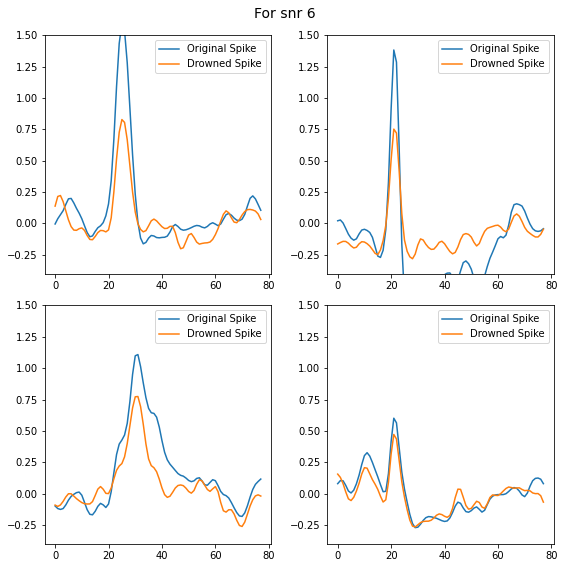

In [3]:
# generate datasets
preprocessing.it_genLoaders( 
    batchSize,
    includedSims,
    doPrint=True,
    snrs=snrs,
    inclusionThreshold=0.5,
    iterations=iters,
    baseDatasetPath=baseDatasetPath
)

In [4]:
# run thresholding pipeline iters times

def thresholdDefault2():
    return {}

def thresholdDefault1():
    return defaultdict(thresholdDefault2)

thresholdingRes = defaultdict(thresholdDefault1)

for i in range(1, iters + 1):
    print(f"\nIteration {i}\n")
    
    trainSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainSpikesLoader.pickle", "rb"))
    trainBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-trainBgLoader.pickle", "rb"))
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    for snr in snrs:
        print(f"\nThresholding dataset with snr {snr}\n")

        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))

        mean, sd = thresholding.computeThreshold(trainSpikesLoader, valSpikesLoader, testSpikesLoader, trainBgLoader, valBgLoader, testBgLoader)

        for sdMul in sdMuls:
            pred = thresholding.thresholdDatasets(mean, sdMul * sd, testSpikesLoader, testBgLoader)

            labels = np.concatenate(([1 for _ in range(0,len(testSpikesLoader.dataset))],[0 for _ in range(0,len(testBgLoader.dataset))]),axis=0)

            confusionMatrix = testingPipeline.confusionMatrix(labels,pred)

            accuracy, sensitivity, specificity, f1 = testingPipeline.metrics(confusionMatrix)

            thresholdingRes[i][sdMul][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

            print(f"Results for {sdMul} sd")
            print(confusionMatrix)
            print(f"Accuracy: {accuracy}")
            print(f"Sensitivity: {sensitivity}")
            print(f"Specificity: {specificity}")

pickle.dump(thresholdingRes, open(f"{resultsPath}/thresholdingRes.pickle", "wb"))



Iteration 1


Thresholding dataset with snr 1

Results for 1 sd
[[ 4260 16394]
 [ 1087 19567]]
Accuracy: 0.5768132080952842
Sensitivity: 0.9473709693037669
Specificity: 0.20625544688680159
Results for 2 sd
[[16944  3710]
 [10121 10533]]
Accuracy: 0.6651738162099351
Sensitivity: 0.5099738549433523
Specificity: 0.8203737774765179
Results for 3 sd
[[20152   502]
 [16983  3671]]
Accuracy: 0.5767163745521449
Sensitivity: 0.17773796843226494
Specificity: 0.9756947806720248
Results for 4 sd
[[20606    48]
 [19437  1217]]
Accuracy: 0.5282996029824731
Sensitivity: 0.0589232110002905
Specificity: 0.9976759949646558
Results for 5 sd
[[20647     7]
 [20250   404]]
Accuracy: 0.5096107291565798
Sensitivity: 0.01956037571414738
Specificity: 0.9996610825990123

Thresholding dataset with snr 2

Results for 1 sd
[[ 4358 16296]
 [  226 20428]]
Accuracy: 0.6000290500629418
Sensitivity: 0.9890578096252541
Specificity: 0.2110002905006294
Results for 2 sd
[[17042  3612]
 [ 6131 14523]]
Accuracy: 0.764137697


Iteration 2

Training GANs
Separating validation noise
torch.Size([20643, 80])
Separating test noise
torch.Size([20654, 80])

Separating dataset with snr 1

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.4
Threshold: 0.4
Sensitivity: 0.8602431817080851
Specificity: 0.8168386377948942
Accuracy: 0.8385409097514896
Separating test spikes
torch.Size([20654, 80])


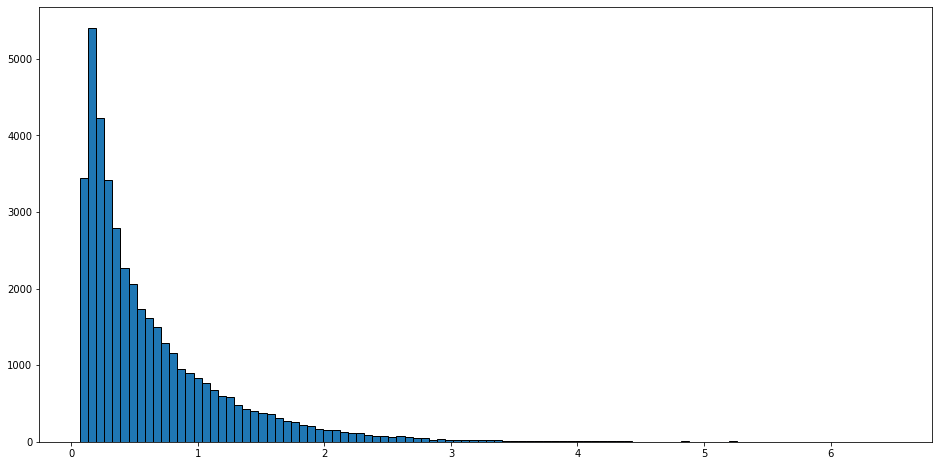

Threshold for best F1: 0.4
Threshold: 0.4
Sensitivity: 0.8646751234627675
Specificity: 0.8170330202382106
Accuracy: 0.840854071850489

Separating dataset with snr 2

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.55
Threshold: 0.55
Sensitivity: 0.9378481809814465
Specificity: 0.9204572978733712
Accuracy: 0.9291527394274088
Separating test spikes
torch.Size([20654, 80])


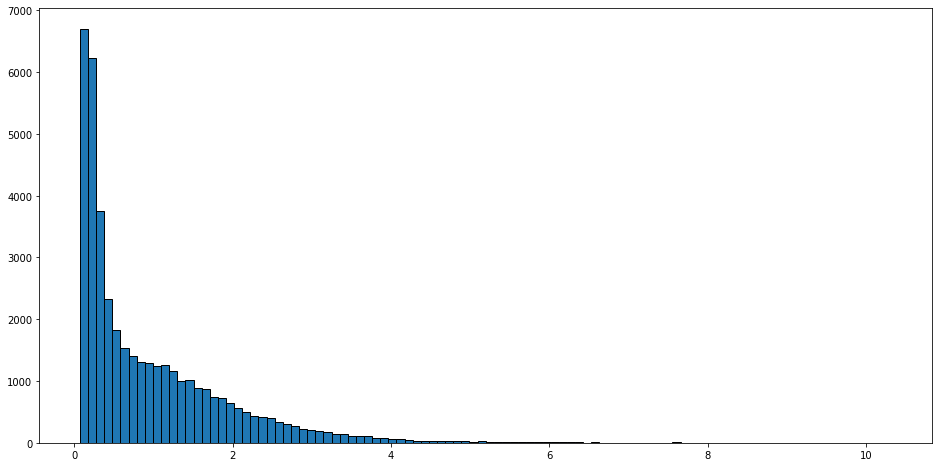

Threshold for best F1: 0.55
Threshold: 0.55
Sensitivity: 0.9354604434976276
Specificity: 0.9190471579355088
Accuracy: 0.9272538007165683

Separating dataset with snr 3

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9635711863585719
Specificity: 0.965412004069176
Accuracy: 0.964491595213874
Separating test spikes
torch.Size([20654, 80])


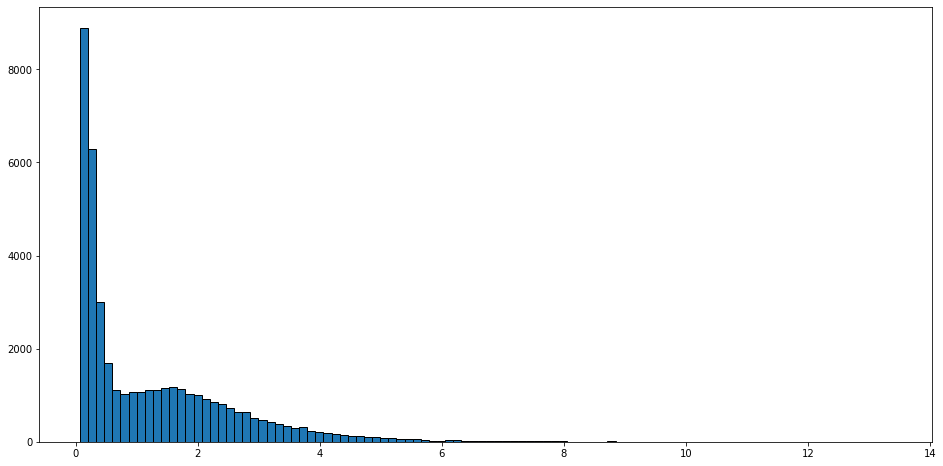

Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9606371647138569
Specificity: 0.9645589232110003
Accuracy: 0.9625980439624285

Separating dataset with snr 4

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.8
Threshold: 0.8
Sensitivity: 0.9806229714673255
Specificity: 0.978685268614058
Accuracy: 0.9796541200406917
Separating test spikes
torch.Size([20654, 80])


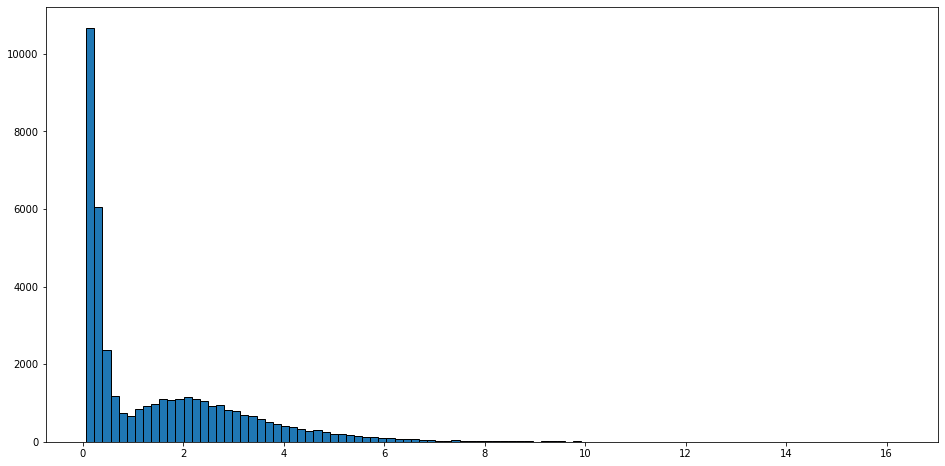

Threshold for best F1: 0.8
Threshold: 0.8
Sensitivity: 0.9782124527936478
Specificity: 0.9796649559407379
Accuracy: 0.9789387043671928

Separating dataset with snr 5

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.9
Threshold: 0.9
Sensitivity: 0.9876955868817516
Specificity: 0.9874049314537615
Accuracy: 0.9875502591677566
Separating test spikes
torch.Size([20654, 80])


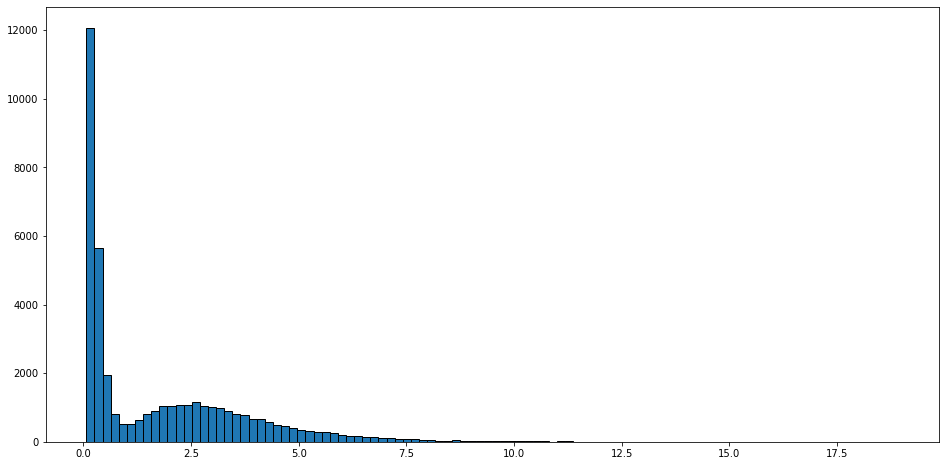

Threshold for best F1: 0.9
Threshold: 0.9
Sensitivity: 0.9856686356153772
Specificity: 0.987460056163455
Accuracy: 0.9865643458894161

Separating dataset with snr 6

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 1.0
Threshold: 1.0
Sensitivity: 0.9912803371602965
Specificity: 0.9920554183016035
Accuracy: 0.99166787773095
Separating test spikes
torch.Size([20654, 80])


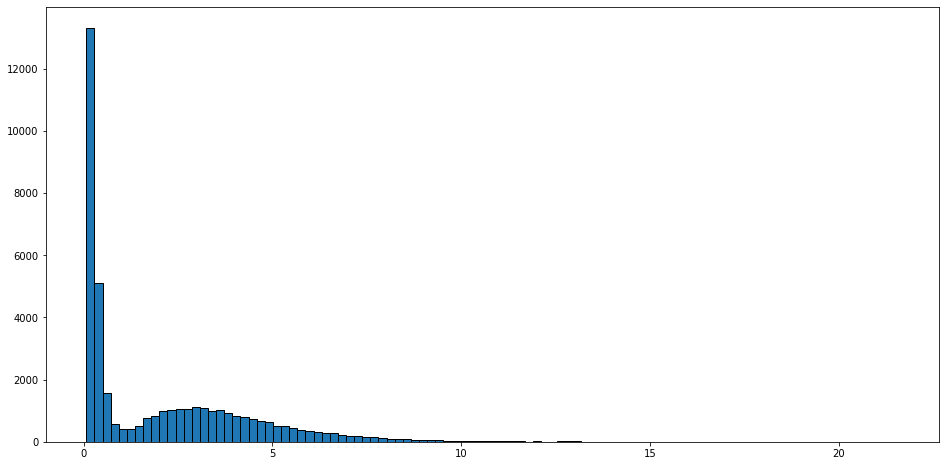

Threshold for best F1: 1.0
Threshold: 1.0
Sensitivity: 0.9899777282850779
Specificity: 0.9928827345792582
Accuracy: 0.9914302314321681

Iteration 3

Training GANs
Separating validation noise
torch.Size([20643, 80])
Separating test noise
torch.Size([20654, 80])

Separating dataset with snr 1

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.35
Threshold: 0.35
Sensitivity: 0.8129147895170276
Specificity: 0.7989633289735019
Accuracy: 0.8059390592452648
Separating test spikes
torch.Size([20654, 80])


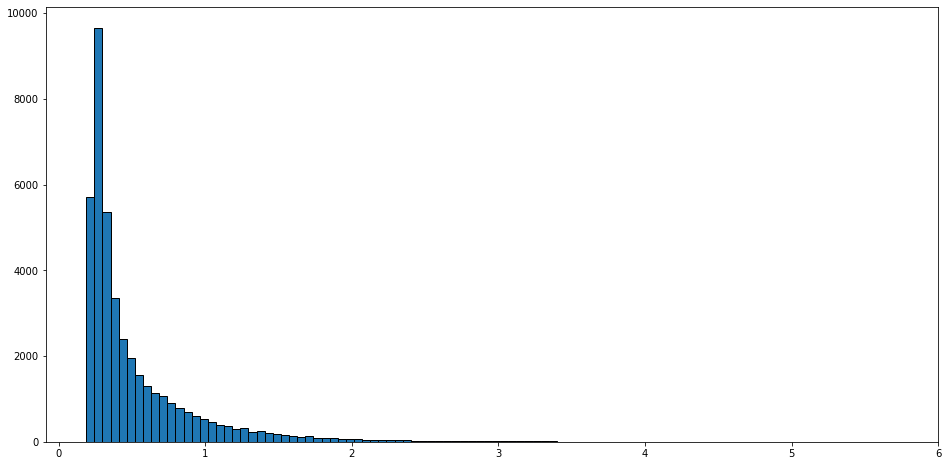

Threshold for best F1: 0.35
Threshold: 0.35
Sensitivity: 0.809867338045899
Specificity: 0.7960685581485426
Accuracy: 0.8029679480972208

Separating dataset with snr 2

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.45
Threshold: 0.45
Sensitivity: 0.88480356537325
Specificity: 0.9228309838686237
Accuracy: 0.9038172746209369
Separating test spikes
torch.Size([20654, 80])


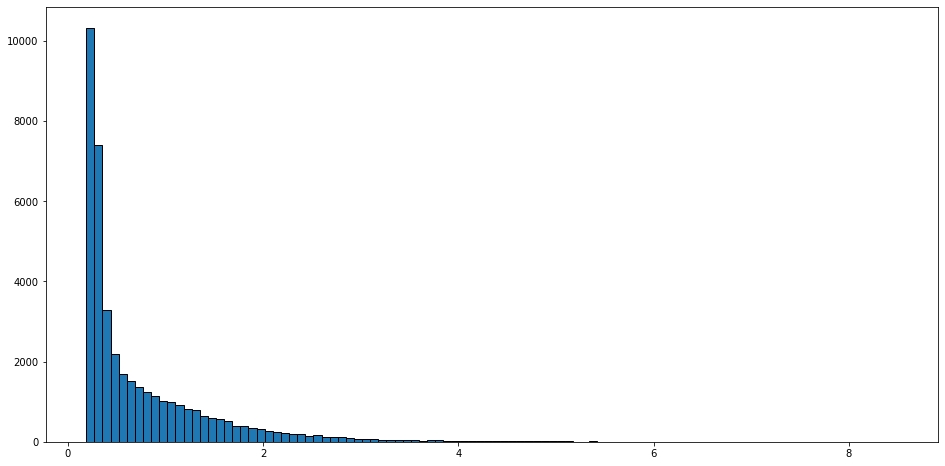

Threshold for best F1: 0.45
Threshold: 0.45
Sensitivity: 0.884816500435751
Specificity: 0.920644911397308
Accuracy: 0.9027307059165295

Separating dataset with snr 3

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.5
Threshold: 0.5
Sensitivity: 0.9388170324080802
Specificity: 0.9506854623843434
Accuracy: 0.9447512473962117
Separating test spikes
torch.Size([20654, 80])


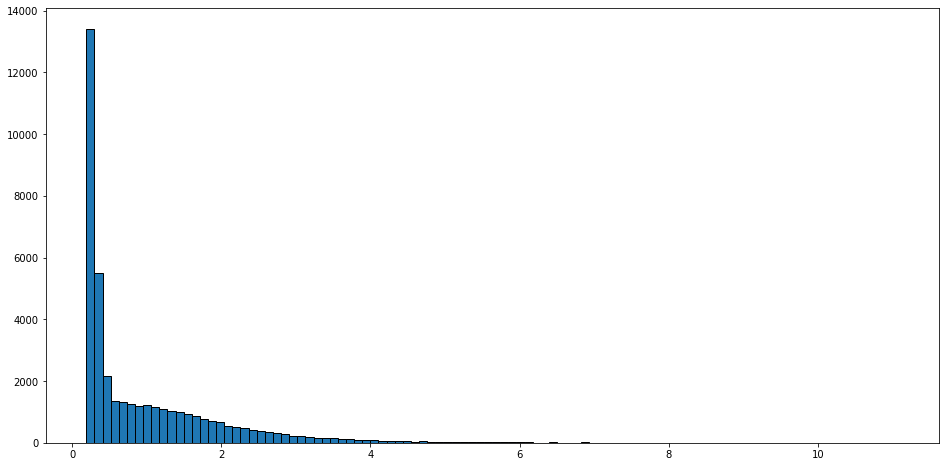

Threshold for best F1: 0.5
Threshold: 0.5
Sensitivity: 0.9400600367967464
Specificity: 0.9480488041057422
Accuracy: 0.9440544204512443

Separating dataset with snr 4

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.6
Threshold: 0.6
Sensitivity: 0.9517027563823087
Specificity: 0.9783461706147363
Accuracy: 0.9650244634985226
Separating test spikes
torch.Size([20654, 80])


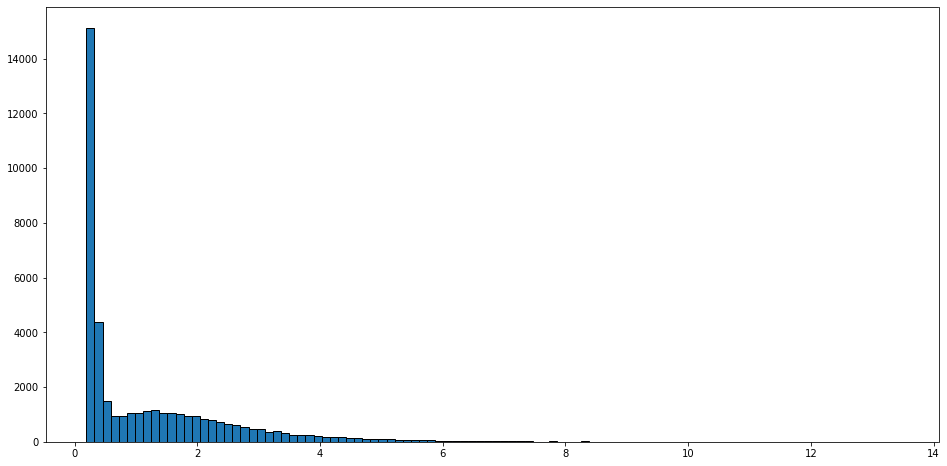

Threshold for best F1: 0.6
Threshold: 0.6
Sensitivity: 0.9538588166941029
Specificity: 0.9769536167328362
Accuracy: 0.9654062167134696

Separating dataset with snr 5

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9650244634985226
Specificity: 0.9860000968851427
Accuracy: 0.9755122801918326
Separating test spikes
torch.Size([20654, 80])


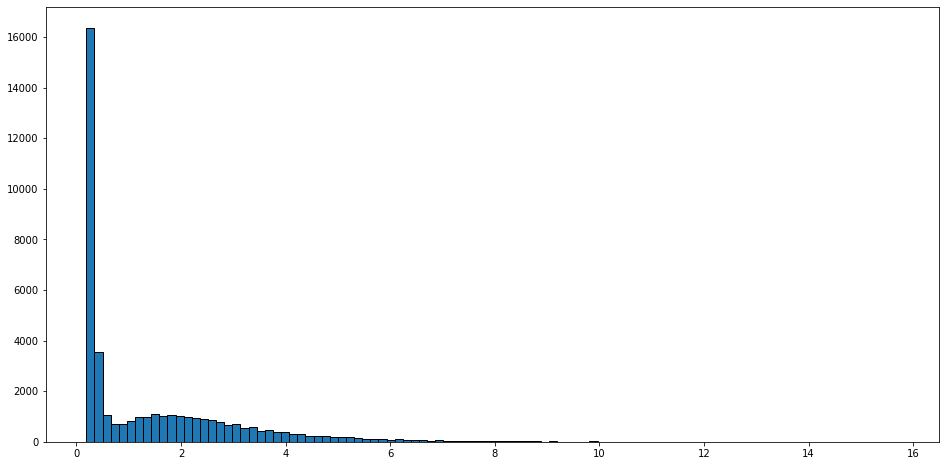

Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9683354313934347
Specificity: 0.9837319647525903
Accuracy: 0.9760336980730125

Separating dataset with snr 6

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9772804340454392
Specificity: 0.9860000968851427
Accuracy: 0.9816402654652909
Separating test spikes
torch.Size([20654, 80])


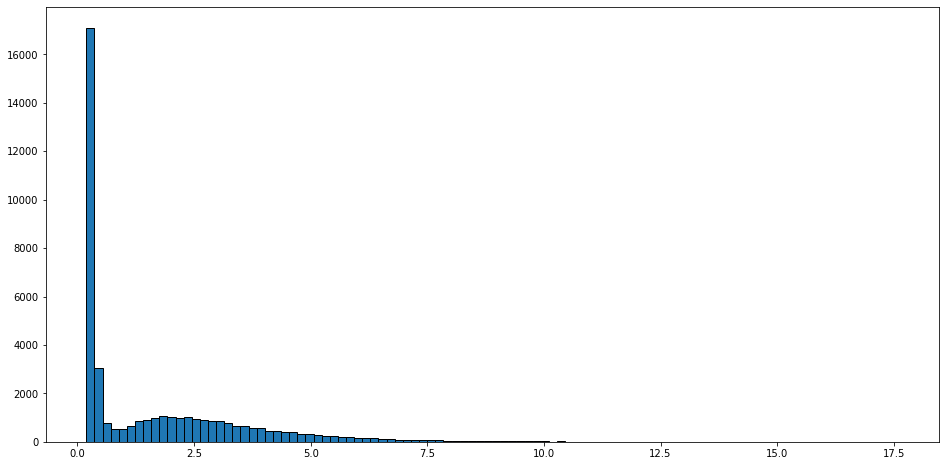

Threshold for best F1: 0.7
Threshold: 0.65
Sensitivity: 0.9795197056260289
Specificity: 0.9837319647525903
Accuracy: 0.9816258351893096

Iteration 4

Training GANs
Separating validation noise
torch.Size([20643, 80])
Separating test noise
torch.Size([20654, 80])

Separating dataset with snr 1

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.3
Threshold: 0.3
Sensitivity: 0.8614542459913772
Specificity: 0.7410744562321367
Accuracy: 0.801264351111757
Separating test spikes
torch.Size([20654, 80])


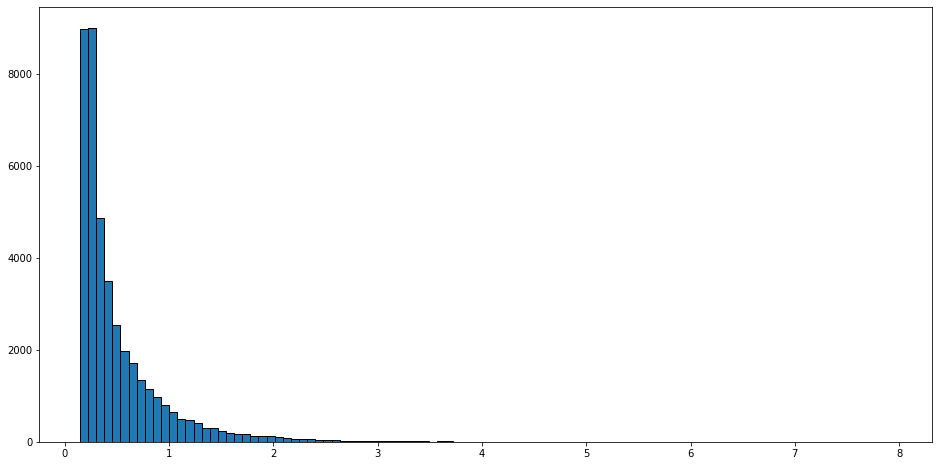

Threshold for best F1: 0.3
Threshold: 0.3
Sensitivity: 0.8636583712598044
Specificity: 0.7371453471482522
Accuracy: 0.8004018592040283

Separating dataset with snr 2

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.4
Threshold: 0.4
Sensitivity: 0.9262219638618417
Specificity: 0.8837378288039529
Accuracy: 0.9049798963328973
Separating test spikes
torch.Size([20654, 80])


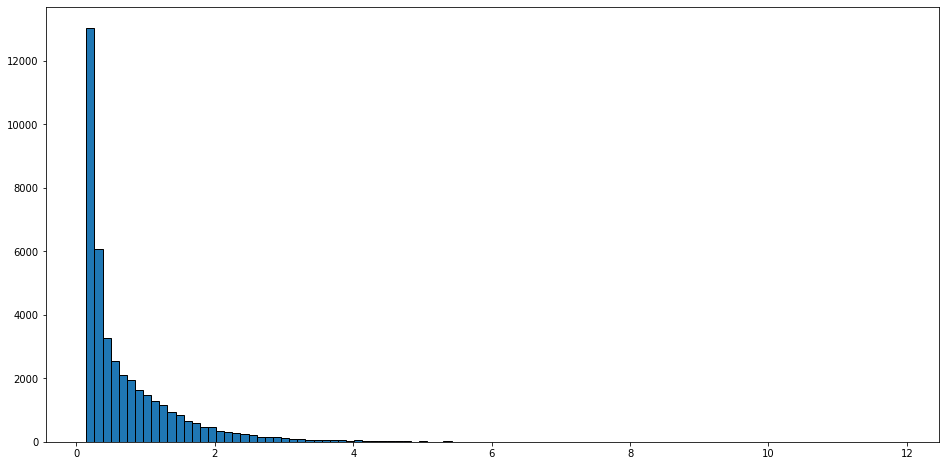

Threshold for best F1: 0.4
Threshold: 0.4
Sensitivity: 0.9251960879248572
Specificity: 0.8868500048416772
Accuracy: 0.9060230463832671

Separating dataset with snr 3

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.5
Threshold: 0.5
Sensitivity: 0.9536404592355763
Specificity: 0.9446785835392143
Accuracy: 0.9491595213873952
Separating test spikes
torch.Size([20654, 80])


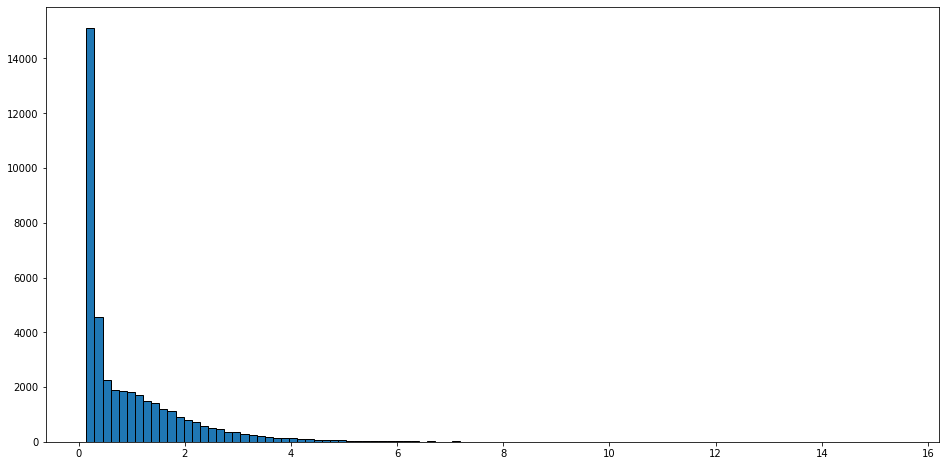

Threshold for best F1: 0.5
Threshold: 0.5
Sensitivity: 0.9525999806332913
Specificity: 0.9465478841870824
Accuracy: 0.9495739324101868

Separating dataset with snr 4

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.6
Threshold: 0.6
Sensitivity: 0.9673981494937751
Specificity: 0.9725330620549338
Accuracy: 0.9699656057743545
Separating test spikes
torch.Size([20654, 80])


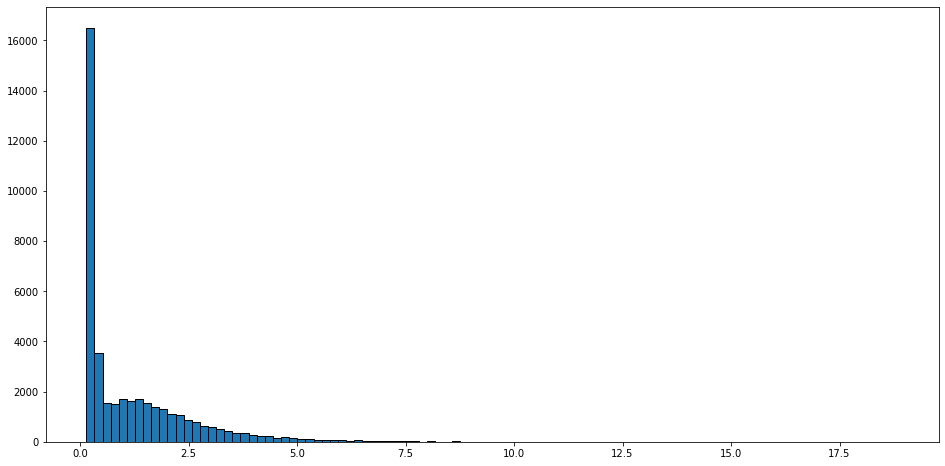

Threshold for best F1: 0.55
Threshold: 0.6
Sensitivity: 0.9667376779316356
Specificity: 0.9743875278396437
Accuracy: 0.9705626028856396

Separating dataset with snr 5

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9813496100373008
Specificity: 0.980235430896672
Accuracy: 0.9807925204669864
Separating test spikes
torch.Size([20654, 80])


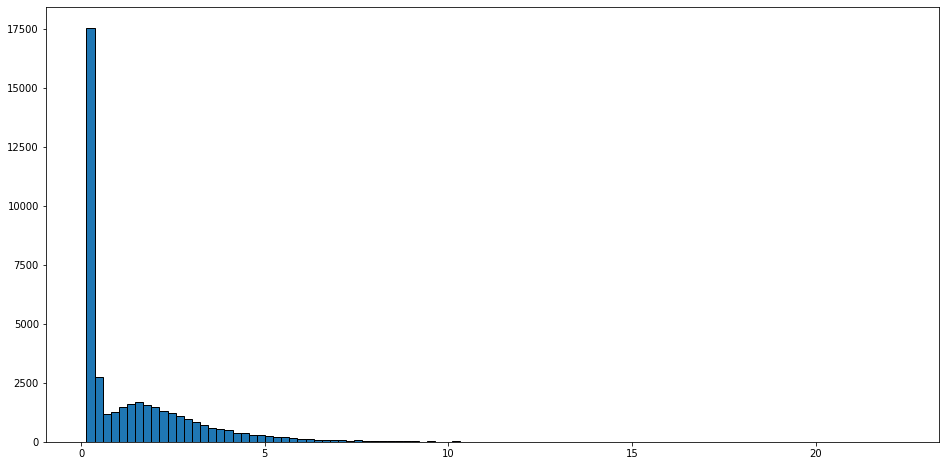

Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9819405442045125
Specificity: 0.9820373777476518
Accuracy: 0.9819889609760821

Separating dataset with snr 6

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9884706680230587
Specificity: 0.9861938671704694
Accuracy: 0.9873322675967641
Separating test spikes
torch.Size([20654, 80])


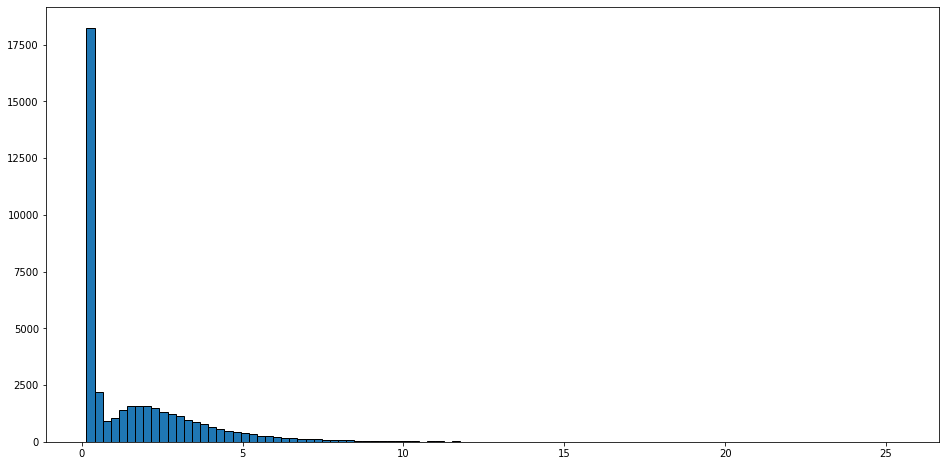

Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9880410574222911
Specificity: 0.986588554275201
Accuracy: 0.987314805848746

Iteration 5

Training GANs
Separating validation noise
torch.Size([20643, 80])
Separating test noise
torch.Size([20654, 80])

Separating dataset with snr 1

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.45
Threshold: 0.45
Sensitivity: 0.7812333478661048
Specificity: 0.7133168628590806
Accuracy: 0.7472751053625927
Separating test spikes
torch.Size([20654, 80])


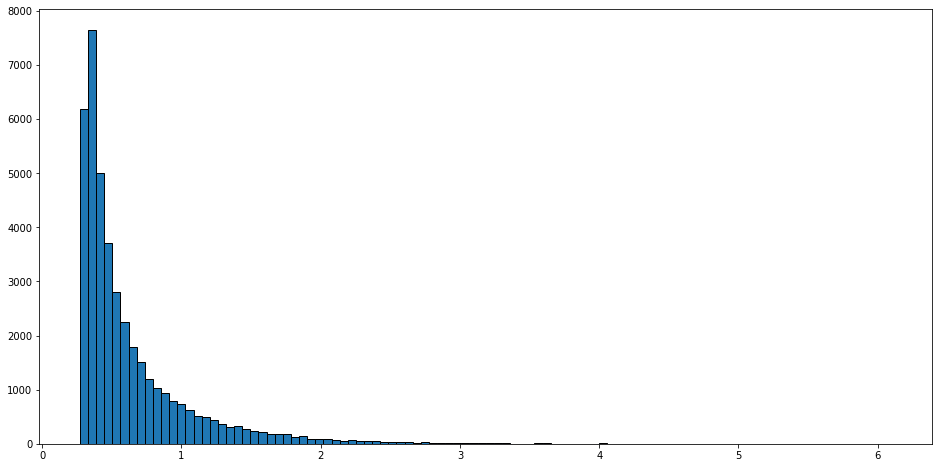

Threshold for best F1: 0.45
Threshold: 0.45
Sensitivity: 0.782753945966883
Specificity: 0.7106129563280721
Accuracy: 0.7466834511474775

Separating dataset with snr 2

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.55
Threshold: 0.55
Sensitivity: 0.8597587559947683
Specificity: 0.8567553165722036
Accuracy: 0.8582570362834859
Separating test spikes
torch.Size([20654, 80])


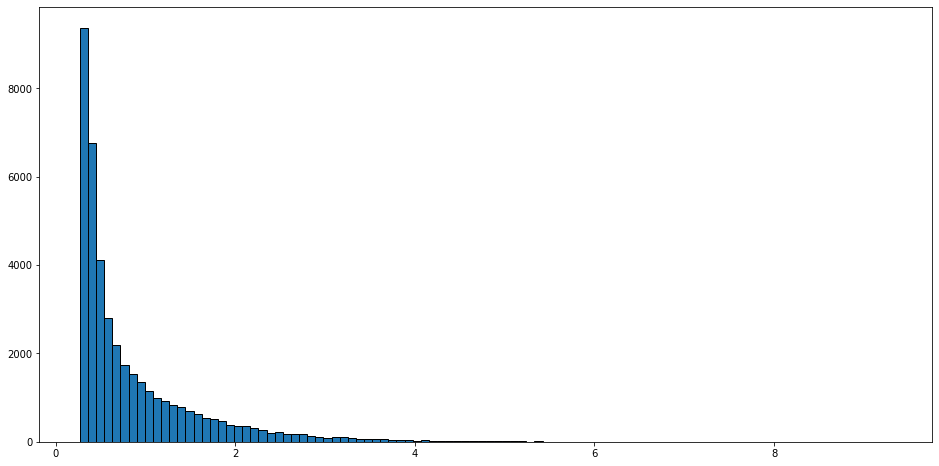

Threshold for best F1: 0.55
Threshold: 0.55
Sensitivity: 0.8643362060617799
Specificity: 0.8580420257577225
Accuracy: 0.8611891159097511

Separating dataset with snr 3

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9031148573366274
Specificity: 0.926657947003827
Accuracy: 0.9148864021702272
Separating test spikes
torch.Size([20654, 80])


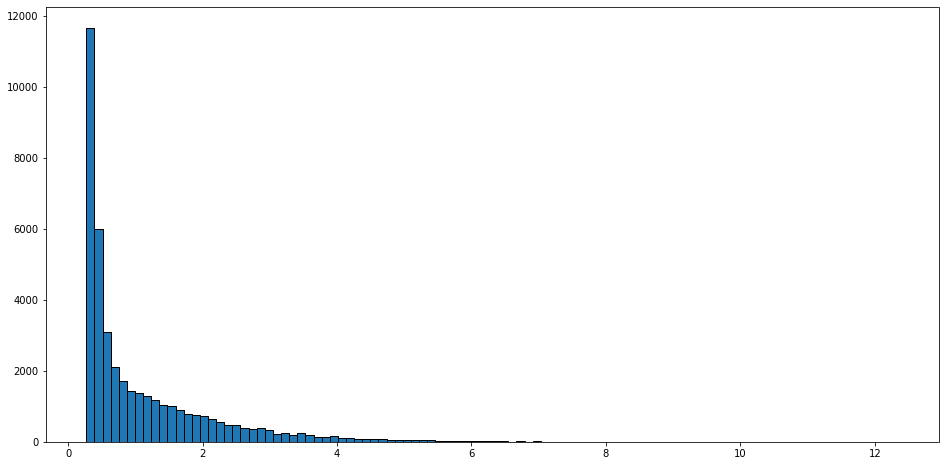

Threshold for best F1: 0.65
Threshold: 0.65
Sensitivity: 0.9058777960685581
Specificity: 0.9277621768180497
Accuracy: 0.916819986443304

Separating dataset with snr 4

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9399796541200407
Specificity: 0.9474882526764521
Accuracy: 0.9437339533982464
Separating test spikes
torch.Size([20654, 80])


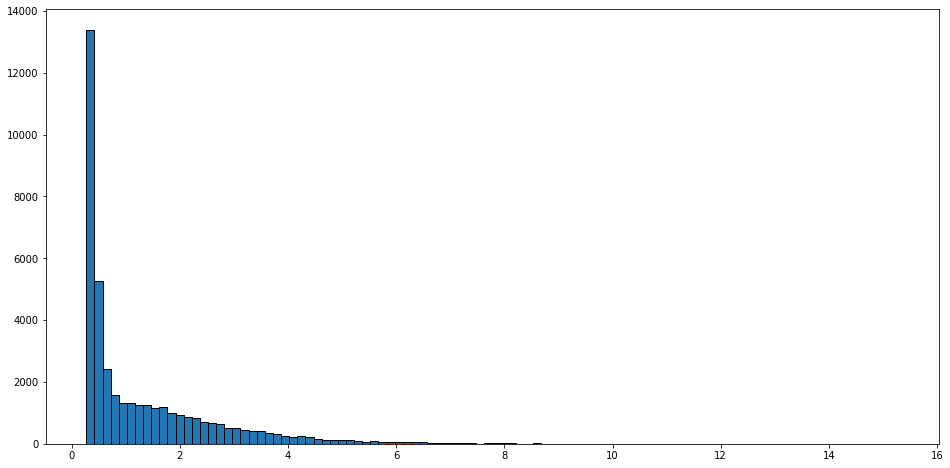

Threshold for best F1: 0.7
Threshold: 0.7
Sensitivity: 0.9423356250605209
Specificity: 0.9499370581969594
Accuracy: 0.9461363416287402

Separating dataset with snr 5

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.8
Threshold: 0.8
Sensitivity: 0.9490868575303977
Specificity: 0.9744223223368697
Accuracy: 0.9617545899336337
Separating test spikes
torch.Size([20654, 80])


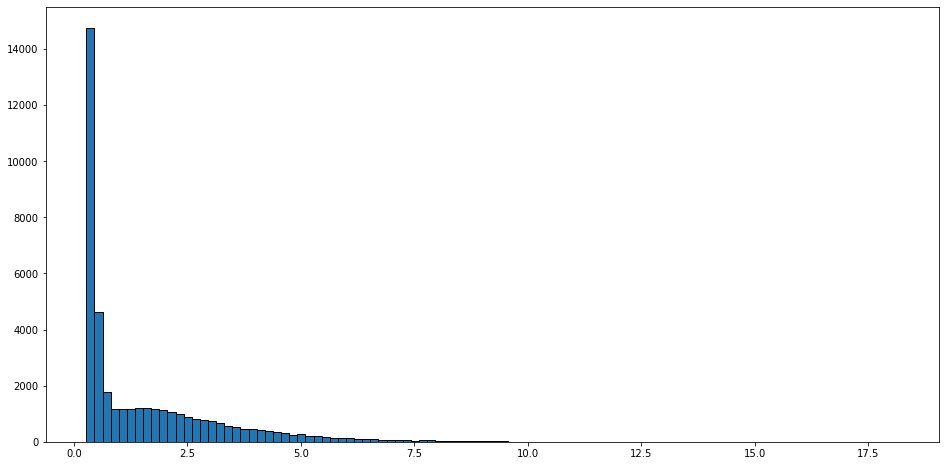

Threshold for best F1: 0.8
Threshold: 0.8
Sensitivity: 0.9521642296891644
Specificity: 0.9746780284690617
Accuracy: 0.963421129079113

Separating dataset with snr 6

Separating validation spikes
torch.Size([20643, 80])
Threshold for best F1: 0.85
Threshold: 0.85
Sensitivity: 0.962166351789953
Specificity: 0.9814949377512958
Accuracy: 0.9718306447706244
Separating test spikes
torch.Size([20654, 80])


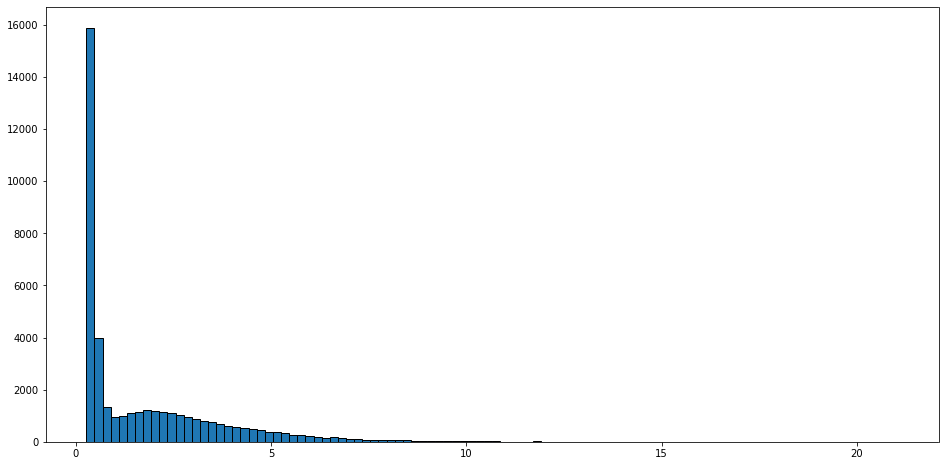

Threshold for best F1: 0.8
Threshold: 0.85
Sensitivity: 0.96460733998257
Specificity: 0.9815047932603854
Accuracy: 0.9730560666214777


PicklingError: Can't pickle <function defaultSep at 0x7fb768098dc0>: it's not the same object as __main__.defaultSep

In [9]:
# run the separation pipeline iters times

def defaultSep():
    return {}

#separationRes = defaultdict(defaultSep)


for i in range(2, iters + 1):
    print(f"\nIteration {i}\n")
    
    print("Training GANs")
    gans.spawnTrainingProcesses(baseDatasetPath, i, baseModelPath, batchSize, noiseDim, epochs)

    genSpike = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticSpike = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-spike.pth"))
    genSpike.to(gans.device)
    criticSpike.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-spike.pth"))
    criticSpike.to(gans.device)
    
    genNoise = gans.GeneratorWgan(inputSize=noiseDim, hiddenSize=80, outputSize=80)
    criticNoise = gans.CriticWgan(inputSize=80, hiddenSize=40)
    genNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-gen-noise.pth"))
    genNoise.to(gans.device)
    criticNoise.load_state_dict(torch.load(f"{baseModelPath}/it-{i}-critic-noise.pth"))
    criticNoise.to(gans.device)
    
    valBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-valBgLoader.pickle", "rb"))
    testBgLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-non-drowned-testBgLoader.pickle", "rb"))
    
    # separating noise as it is the same for all snrs
    
    print("Separating validation noise")
    
    (cleanextractedSpikesValidationBg,cleanextractedNoisesValidationBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        loader_mix=valBgLoader,
        epochs=3000
    )
    
    print("Separating test noise")
    
    (cleanextractedSpikesTestBg,cleanextractedNoisesTestBg) = sourceSeparation.maxlikelihood_separatesources(
        generators=[genSpike, genNoise],
        loader_mix=testBgLoader,
        epochs=3000
    )

    for snr in snrs:
        print(f"\nSeparating dataset with snr {snr}\n")
        
        valSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-valSpikesLoader.pickle", "rb"))
        testSpikesLoader = pickle.load(open(f"{baseDatasetPath}/it-{i}-snr-{snr}-testSpikesLoader.pickle", "rb"))
        
        print("Separating validation spikes")
        
        (cleanextractedSpikesValidationSpikes,cleanextractedNoisesValidationSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            loader_mix=valSpikesLoader,
            epochs=3000
        )
        
        valExtractedSpikes = np.concatenate((cleanextractedSpikesValidationSpikes,cleanextractedSpikesValidationBg),axis=0)
        valExtractedSpikes = torch.from_numpy(valExtractedSpikes)
        vallabel = np.concatenate(([1 for _ in cleanextractedSpikesValidationSpikes],[0 for _ in cleanextractedSpikesValidationBg]),axis=0)
        
        valThreshold, _, _, _, _, _ = testingPipeline.interpretSeparation(valExtractedSpikes, criticSpike, vallabel,method="energy")
        
        print("Separating test spikes")
        
        (cleanextractedSpikesTestSpikes,cleanextractedNoisesTestSpikes) = sourceSeparation.maxlikelihood_separatesources(
            generators=[genSpike, genNoise],
            loader_mix=testSpikesLoader,
            epochs=3000
        )
        
        testExtractedSpikes = np.concatenate((cleanextractedSpikesTestSpikes,cleanextractedSpikesTestBg),axis=0)
        testExtractedSpikes = torch.from_numpy(testExtractedSpikes)
        testlabel = np.concatenate(([1 for _ in cleanextractedSpikesTestSpikes],[0 for _ in cleanextractedSpikesTestBg]),axis=0)
        
        _, confusionMatrix, accuracy, sensitivity, specificity, f1 = testingPipeline.interpretSeparation(testExtractedSpikes, criticSpike, testlabel,test=True, testThreshold=valThreshold,method="energy")

        separationRes[i][snr] = [confusionMatrix, accuracy, sensitivity, specificity, f1]

pickle.dump(dict(separationRes), open(f"{resultsPath}/separationRes.pickle", "wb"))
        
        

In [10]:
separationRes

defaultdict(<function __main__.defaultSep()>,
            {1: {1: [array([[16396,  4258],
                      [ 4712, 15942]]),
               0.7828507795100222,
               0.7718601723637067,
               0.7938413866563377,
               0.7804376560434719],
              2: [array([[18259,  2395],
                      [ 2745, 17909]]),
               0.8755688970659437,
               0.8670959620412511,
               0.8840418320906362,
               0.8745055910933152],
              3: [array([[19352,  1302],
                      [ 1803, 18851]]),
               0.9248329621380846,
               0.9127045608598818,
               0.9369613634162874,
               0.9239101134609259],
              4: [array([[19913,   741],
                      [ 1325, 19329]]),
               0.9499854749685291,
               0.9358477776701849,
               0.9641231722668733,
               0.949268244769669],
              5: [array([[20107,   547],
                      [

In [12]:

pickle.dump(dict(separationRes), open(f"{resultsPath}/separationRes.pickle", "wb"))
        

In [32]:
# Interpret thresholding results
#avgs -> metric -> sd -> values for specific snr
avgs = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: 0)))

thIt = 0

for it in thresholdingRes:
    thIt += 1
    for sd in thresholdingRes[it]:
        for snr in thresholdingRes[it][sd]:
            avgs["accuracy"][sd][snr] += thresholdingRes[it][sd][snr][1]
            avgs["sensitivity"][sd][snr] += thresholdingRes[it][sd][snr][2]
            avgs["specificity"][sd][snr] += thresholdingRes[it][sd][snr][3]
            avgs["f1"][sd][snr] += thresholdingRes[it][sd][snr][4]
for metric in avgs:
    for sd in avgs[metric]:
        for snr in avgs[metric][sd]:
            avgs[metric][sd][snr] /= thIt
print(json.dumps(avgs["specificity"], indent=4))

{
    "1": {
        "1": 0.21282076111164905,
        "2": 0.21758497143410477,
        "3": 0.22203931441851457,
        "4": 0.22656144088312194,
        "5": 0.23119976759949648,
        "6": 0.2354991769148833
    },
    "2": {
        "1": 0.8173913043478261,
        "2": 0.8218843807494917,
        "3": 0.8264355572770408,
        "4": 0.8307252832381137,
        "5": 0.8351989929311514,
        "6": 0.8396920693328169
    },
    "3": {
        "1": 0.9770214002130337,
        "2": 0.9779800522901134,
        "3": 0.9788128207611116,
        "4": 0.9797521061295633,
        "5": 0.9806623414350731,
        "6": 0.9812820761111649
    },
    "4": {
        "1": 0.9971434104773893,
        "2": 0.9972789774377844,
        "3": 0.9974048610438656,
        "4": 0.9976372615474001,
        "5": 0.9977534617991672,
        "6": 0.9978696620509344
    },
    "5": {
        "1": 0.9997482327878376,
        "2": 0.9997869662050934,
        "3": 0.9998256996223491,
        "4": 0.99983538

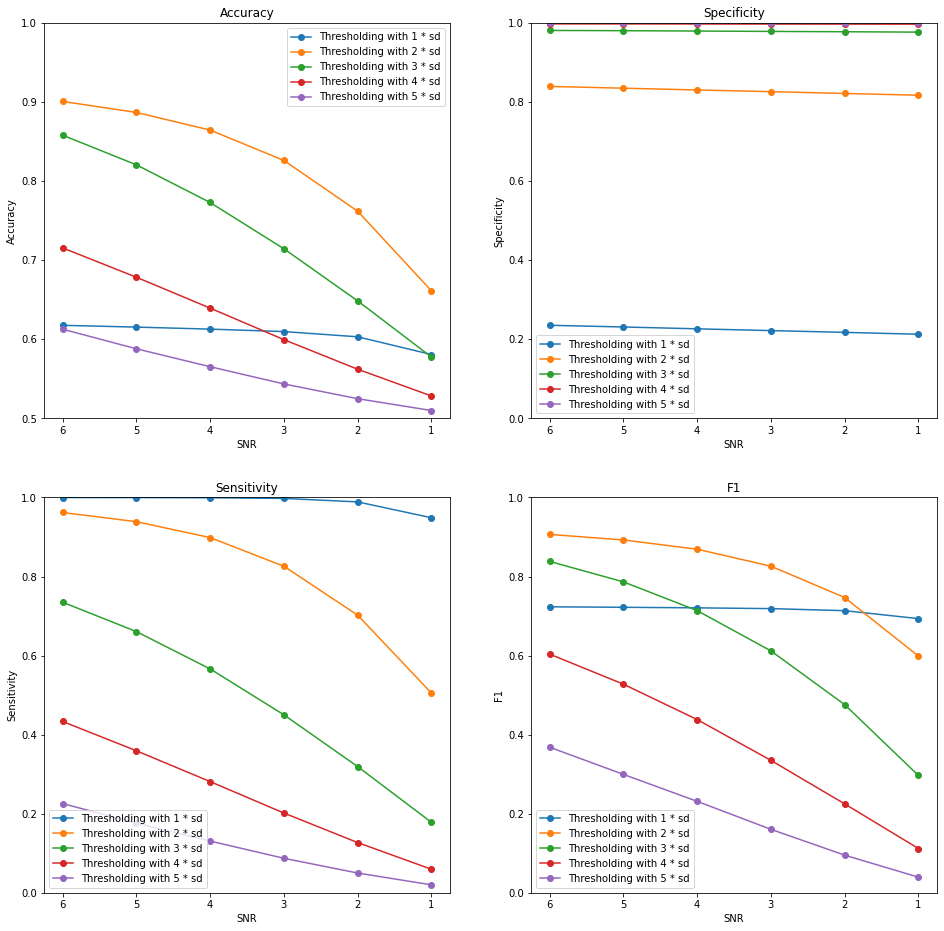

In [33]:
plt.rcParams['figure.figsize'] = [16, 16]

fig, axs = plt.subplots(2,2)

axs[0][0].title.set_text("Accuracy")
axs[0][1].title.set_text("Specificity")
axs[1][0].title.set_text("Sensitivity")
axs[1][1].title.set_text("F1")
axs[0][0].set_xlabel("SNR")
axs[0][1].set_xlabel("SNR")
axs[1][0].set_xlabel("SNR")
axs[1][1].set_xlabel("SNR")
axs[0][0].set_ylabel("Accuracy")
axs[0][1].set_ylabel("Specificity")
axs[1][0].set_ylabel("Sensitivity")
axs[1][1].set_ylabel("F1")

for sd in avgs["accuracy"]:
    axs[0][0].plot(avgs["accuracy"][sd].keys(), avgs["accuracy"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["specificity"]:
    axs[0][1].plot(avgs["specificity"][sd].keys(), avgs["specificity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["sensitivity"]:
    axs[1][0].plot(avgs["sensitivity"][sd].keys(), avgs["sensitivity"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')
for sd in avgs["f1"]:
    axs[1][1].plot(avgs["f1"][sd].keys(), avgs["f1"][sd].values(), label=f"Thresholding with {sd} * sd", marker='o')

axs[0][0].legend()
axs[0][1].legend()
axs[1][0].legend()
axs[1][1].legend()

axs[0][0].set_ylim([0.5,1])
axs[0][1].set_ylim([0,1])
axs[1][0].set_ylim([0,1])
axs[1][1].set_ylim([0,1])
axs[0][0].invert_xaxis()
axs[0][1].invert_xaxis()
axs[1][0].invert_xaxis()
axs[1][1].invert_xaxis()

plt.show()
plt.rcParams['figure.figsize'] = [16, 8]       